In [10]:
#select geno
import h5py
from Bio import SeqIO
import pickle
from matplotlib import pyplot as plt
import numpy as np
#run annot
from scipy.sparse import lil_matrix
import random

In [11]:
treefile = '/scratch/dmoi/projects/covid/validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
alnfile = '/scratch/dmoi/projects/covid/validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnh5 = alnfile+'.h5'

In [12]:
#choose sequence
msa = SeqIO.parse(alnfile , format = 'fasta')
def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

[('EPI_ISL_475635', 0), ('EPI_ISL_425848', 1), ('EPI_ISL_433289', 2), ('EPI_ISL_439066', 3), ('EPI_ISL_433434', 4), ('EPI_ISL_417064', 5), ('EPI_ISL_434563', 6), ('EPI_ISL_434564', 7), ('EPI_ISL_425865', 8), ('EPI_ISL_464788', 9)]


In [13]:
seq = 'EPI_ISL_424471'
print('seq chosen: ' , seq)
#index all non gap cols
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    aln_row = align_array[IDindex[seq],:]
    nongap_cols = [ i for i,c in enumerate(list(aln_row)) if c != b'-' ]
    print('nongap:' , nongap_cols[0:100] , '...')

seq chosen:  EPI_ISL_424471
nongap: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] ...


In [14]:
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    submat_aln = align_array[:,nongap_cols ]

In [15]:
qseq = b''.join(aln_row[nongap_cols])
qfile = 'covid_geno.fasta'
print('qseq' , qseq[0:100])
with open(qfile , 'w') as geno_out:
    geno_out.write((b'>testgeno\n'+qseq).decode())
    #print( (b'>testgeno\n'+qseq).decode())


qseq b'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC'


In [16]:
import subprocess
import shlex
import pandas as pd 

#collapse codons
#use tblastn to map to prots
blastpath = '/scratch/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'
def runblastx( qseq , blastpath = '', outannot = 'outannot.txt' , outfmt = None , db=None):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath + 'blastx -query '+ qfile + ' -db ' +db+' -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot


p,annot = runblastx(qfile , blastpath = blastpath , outannot= alnfile+'outannot.csv' , db = '/scratch/dmoi/projects/covid/validation_data/covid19/covidref_Geno.txt' )
annotation = pd.read_csv( annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

#recluster codons
#load blast results into df

 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
      qseqid                                  sseqid   qlen  slen  qstart  \
0   testgeno   lcl|NC_045512.2_prot_YP_009725295.1_2  29903  4405     266   
5   testgeno   lcl|NC_045512.2_prot_YP_009724389.1_1  29903  7096     266   
6   testgeno   lcl|NC_045512.2_prot_YP_009724389.1_1  29903  7096   13462   
13  testgeno   lcl|NC_045512.2_prot_YP_009724390.1_3  29903  1273   21563   
14  testgeno  lcl|NC_045512.2_prot_YP_009724397.2_11  29903   419   28274   
15  testgeno   lcl|NC_045512.2_prot_YP_009724391.1_4  29903   275   25393   
16  testgeno   lcl|NC_045512.2_prot_YP_009724393.1_6  29903   222   26523   
17  testgeno  lcl|NC_045512.2_prot_YP_009724396.1_10  29903   121   27894   
18  testgeno   lcl|NC_045512.2_prot_YP_009724395.1_8  29903   121   27394   
19  testgeno   lcl|NC_045512.2_prot_YP_009724394.1_7  29903    61   27202   
20  testgeno   lcl|NC_045512.2_prot_YP_009724392.1_5  29903    75   26245   
21  testgeno  lcl

In [18]:
#select longest nice hit
from Bio import Seq
rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []

for ID in annotation.qstart.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))

genes =  {}
prots = {}

for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1].decode()
    #print(genes[i])
    prots[i] = str(Seq.Seq( genes[i]).translate( ) )
annotation = annotation.sort_values( ['qstart'] )
annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
annotation = annotation[annotation.slen < 2000]
aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))
aln_regions= aln_regions[1:,:]
aln_len = np.array(list( annotation.qend - annotation.qstart))

annotation = pd.DataFrame.sort_values(annotation, by='qstart')
print(annotation)

11
10
      qseqid                                  sseqid   qlen  slen  qstart  \
13  testgeno   lcl|NC_045512.2_prot_YP_009724390.1_3  29903  1273   21563   
15  testgeno   lcl|NC_045512.2_prot_YP_009724391.1_4  29903   275   25393   
20  testgeno   lcl|NC_045512.2_prot_YP_009724392.1_5  29903    75   26245   
16  testgeno   lcl|NC_045512.2_prot_YP_009724393.1_6  29903   222   26523   
19  testgeno   lcl|NC_045512.2_prot_YP_009724394.1_7  29903    61   27202   
18  testgeno   lcl|NC_045512.2_prot_YP_009724395.1_8  29903   121   27394   
17  testgeno  lcl|NC_045512.2_prot_YP_009724396.1_10  29903   121   27894   
14  testgeno  lcl|NC_045512.2_prot_YP_009724397.2_11  29903   419   28274   
21  testgeno  lcl|NC_045512.2_prot_YP_009725255.1_12  29903    38   29558   

     qend  qframe         evalue  \
13  25381       2   0.000000e+00   
15  26217       1   0.000000e+00   
20  26469       1   4.410000e-27   
16  27188       3  1.650000e-148   
19  27384       1   3.330000e-35   
18  277

/scratch/dmoi/miniconda/envs/ML/lib/python3.9/site-packages/Bio/Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [21]:
annotation.to_csv(alnfile + 'annotation.csv')

In [48]:
titles = ' codon clusters, svd codon clusters'.split(',')
titles = [ t.replace(' ' , '_') for t in titles]
for k,cluster_labelsb in enumerate([ cluster_labels_codon , cluster_labels_reduced ]):
    l,c = np.unique(cluster_labelsb, return_counts= True)
    clusterdf = { label : [ codon_dict_rev[p] for p in list( np.where(cluster_labelsb == label )[0]  ) if p in codon_dict_rev ] for i,label in enumerate(list(l)) if c[i]> 1 } 
    clusterdf = pd.DataFrame.from_dict( clusterdf , orient = 'index' , dtype=pd.Int64Dtype() )
    print( clusterdf )
    print(clusterdf.index)
    clusterdf.to_csv( alnfile + titles[k] + 'clusterpositions_columns.csv')

     0      1      2      3      4      5      6      7      8      9     ...  \
0    2671   2674   2878   3001   3286   4864   5146   6391   6418   6694  ...   
1     871   2059   2860   3214   5311  20283  22348  24976  26313  26708  ...   
2   22480  22603  25791   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
3    5692   6316  15024  18078  21450  26753  27110  28327   <NA>   <NA>  ...   
4   10327  10630  11974  13722  16794  19845  22342  27726  28007  28324  ...   
5    1876   3241   3370   3739  10774  16863  16956  21823  22036  23710  ...   
6    2392   4228   6565   8233  24067  29026   <NA>   <NA>   <NA>   <NA>  ...   
7    2497   6505   8860  24841  26142  27738   <NA>   <NA>   <NA>   <NA>  ...   
9    6442  14619  14820  20403  25608  25632  26451  27501   <NA>   <NA>  ...   
10   1411  13264  27020  27914   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
11   4135   4294   6079  11329  11830  25482  25536  27537   <NA>   <NA>  ...   
12  21655  23755   <NA>   <N

In [ ]:
protstart = {}
protend = {}
position = 0
for i,r in annotation.iterrows():
    protstart[i] = position 
    position += len( r.prots )
    protend[i] = position
annotation['codon_start'] = annotation.index.map( protstart )
annotation['codon_end'] = annotation.index.map( protend )
print(annotation)

In [176]:
import json
titles = ' codon clusters, svd codon clusters'.split(',')

for k,cluster_labels in enumerate([ cluster_labels_codon , cluster_labels_reduced ]):
    clusters = {}
    for l in np.unique(cluster_labels):
        if len(cluster_labels[ cluster_labels==l ] ) < 200 and len(cluster_labels[ cluster_labels==l ] ) > 4:
            #index of positions
            cluster_postions = np.where( cluster_labels==l )
            for i,r in annotation.iterrows():
                for p in list(cluster_postions[0]):
                    if r.prot_start < p+1 and r.prot_end > p+1:
                        if i not in clusters:
                            clusters[i] = {}
                        if l not in clusters[i]:
                            clusters[i][l] = []
                        clusters[i][l].append(p+1-r.prot_start)
    annotation[titles[k]]= annotation.index.map( clusters )

#annotation['clusters'] = annotation.clusters.map( lambda x : json.dumps( x ) )
print(annotation)

annotation.to_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06_wclusters.csv')

with open( 'annothack.pkl' , 'wb') as annotout:
    annotout.write(pickle.dumps(annotation))

      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065

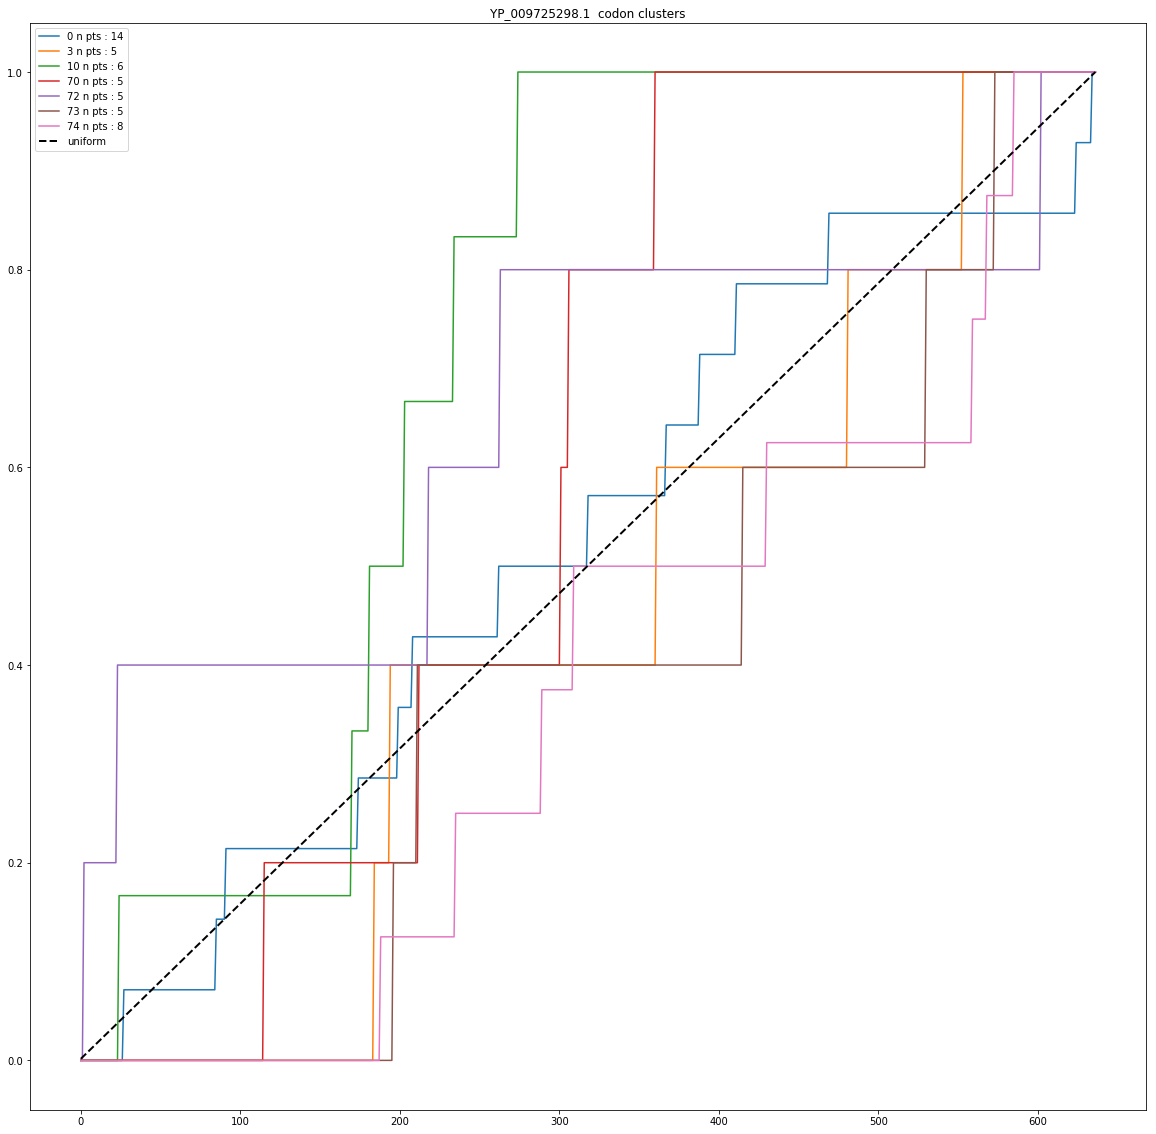

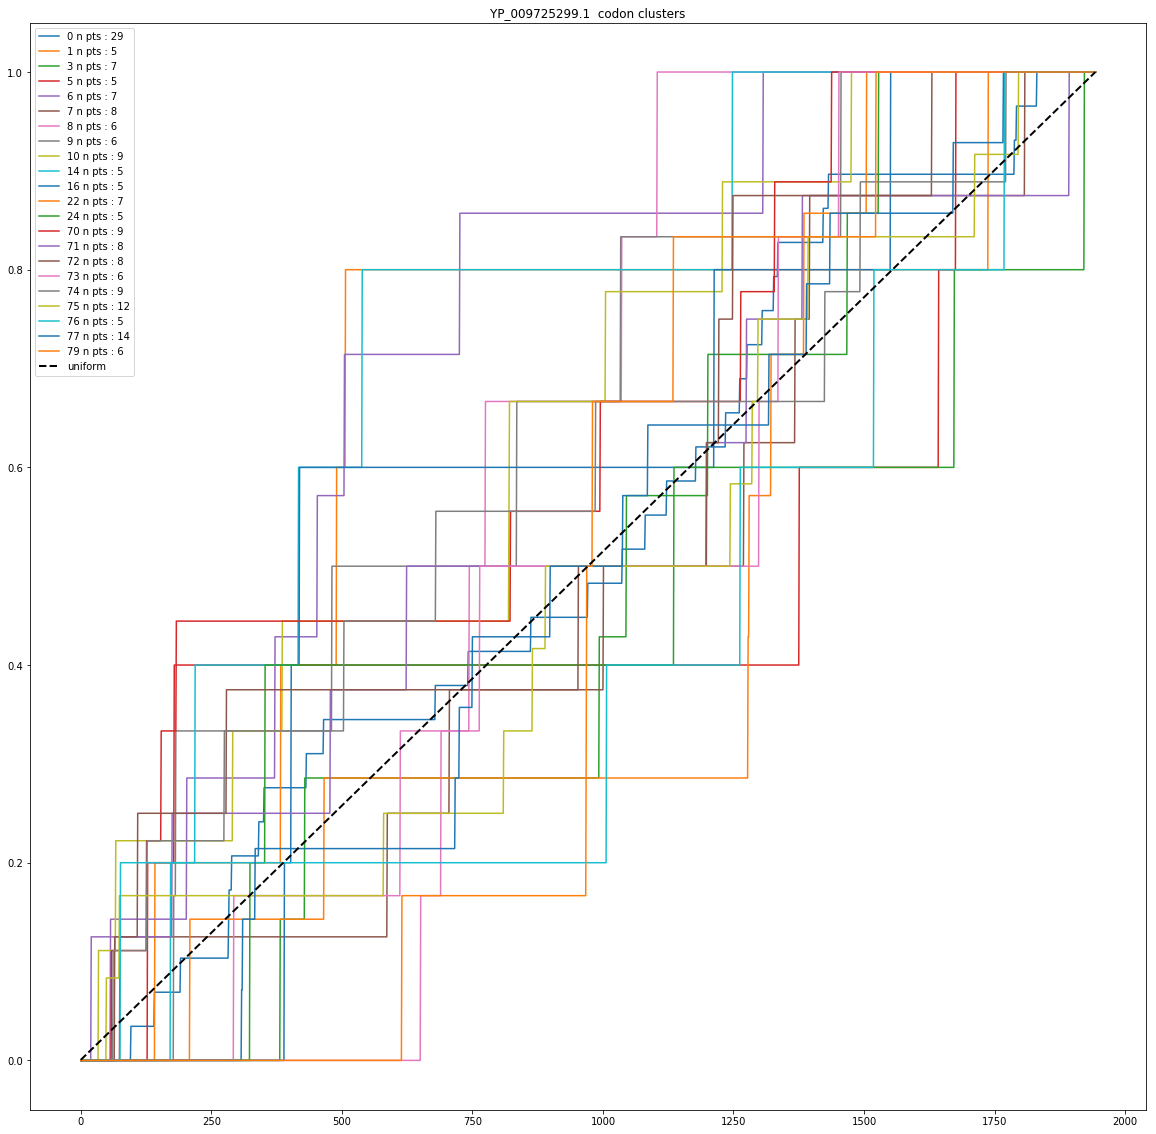

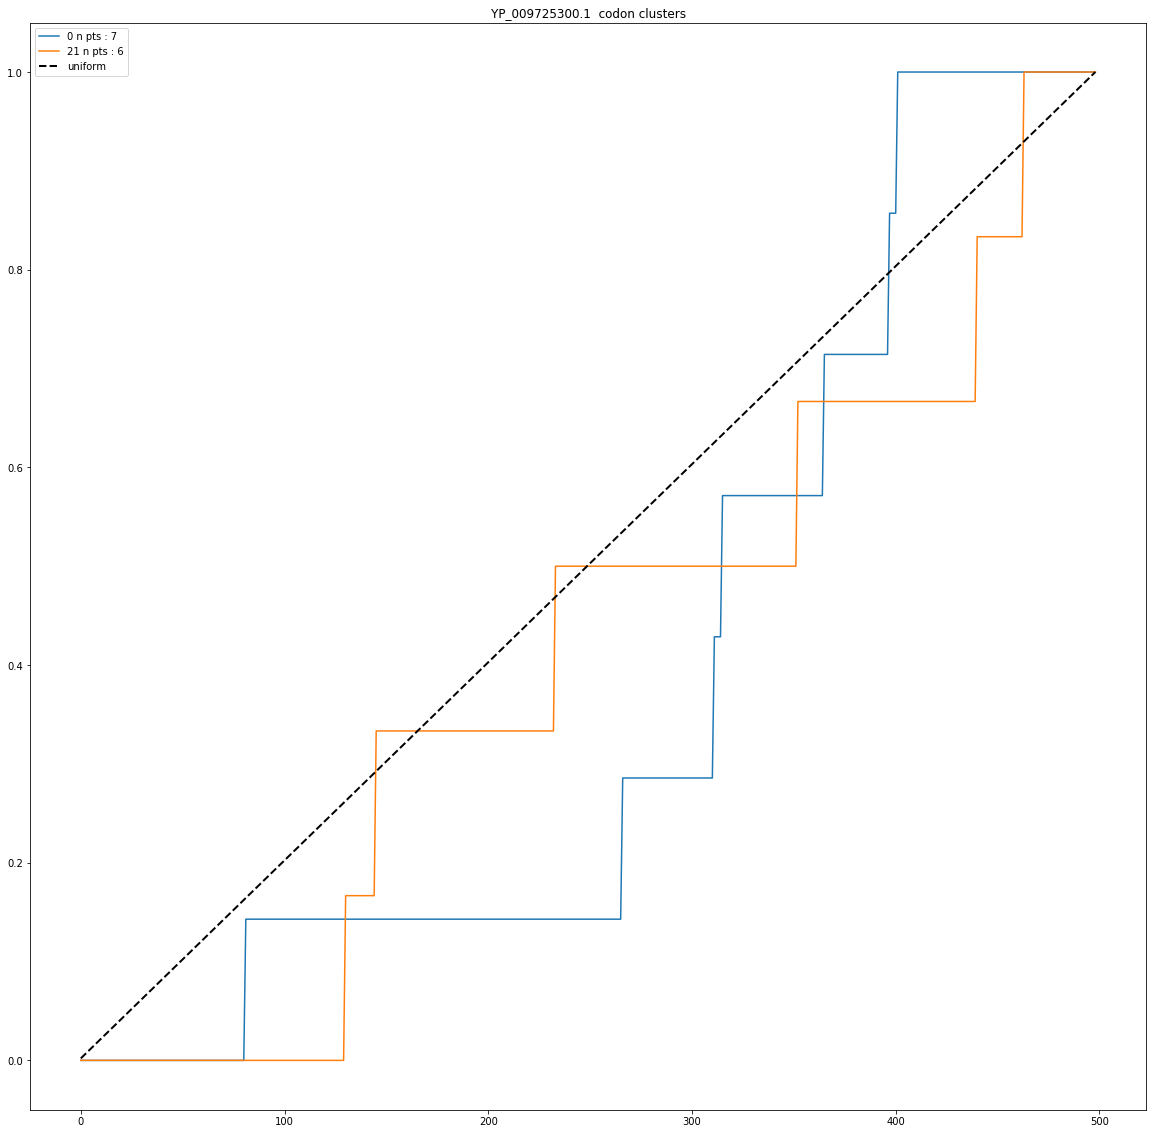

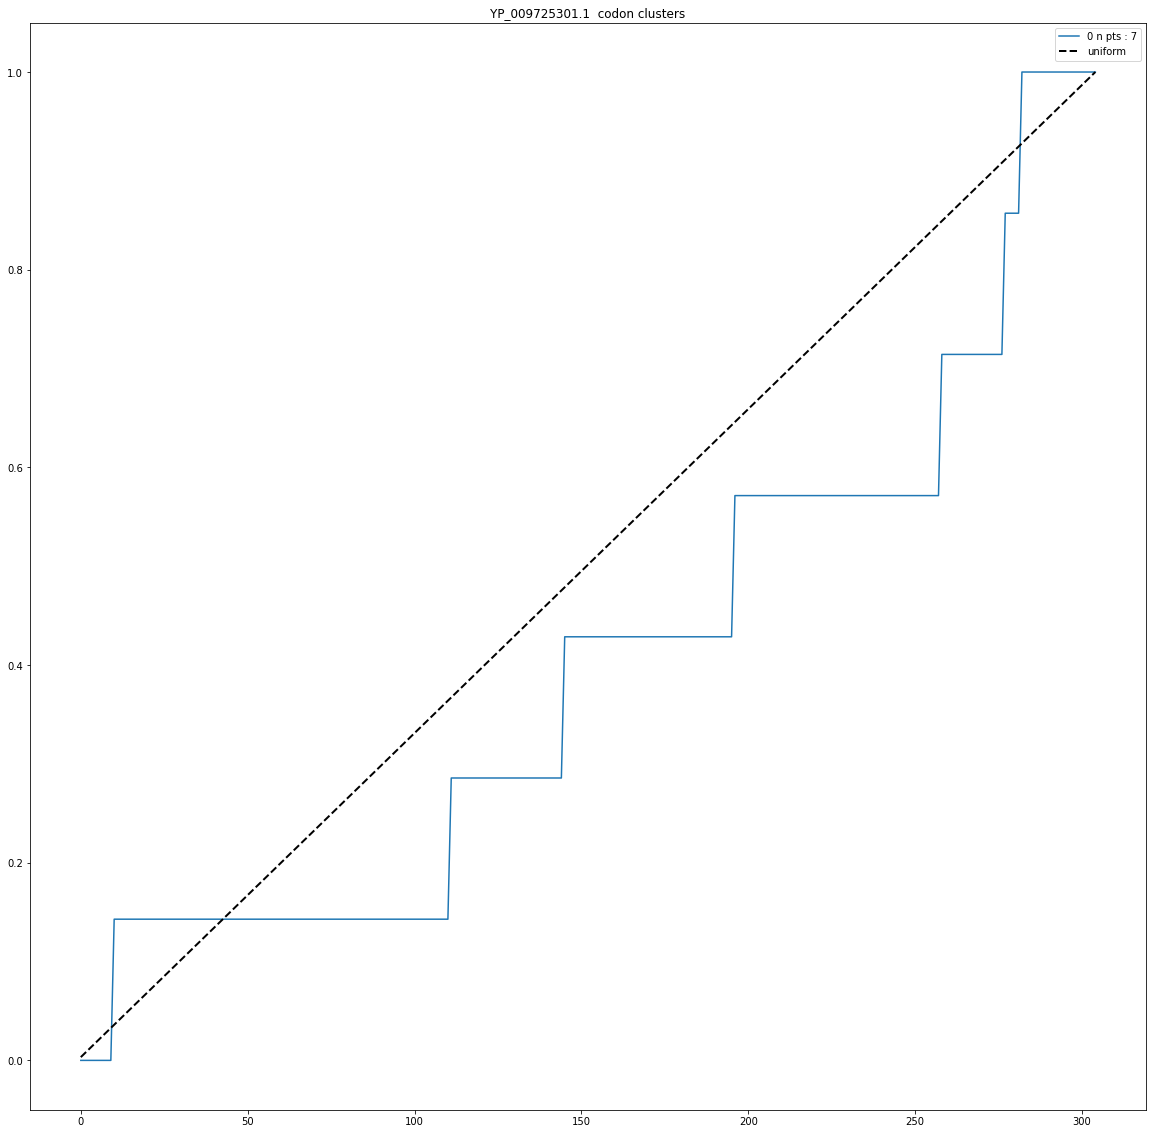

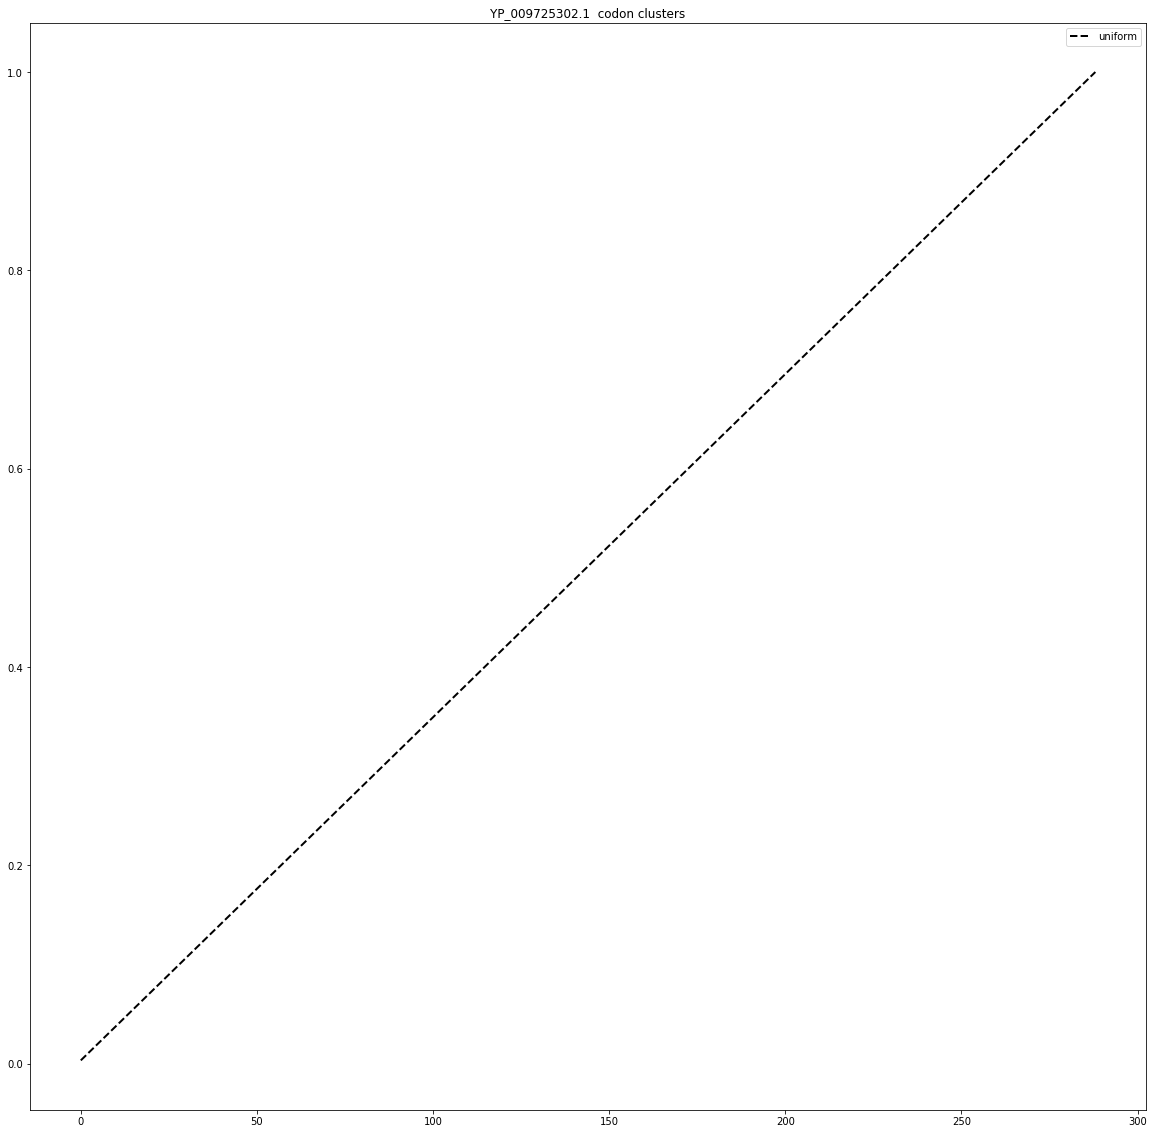

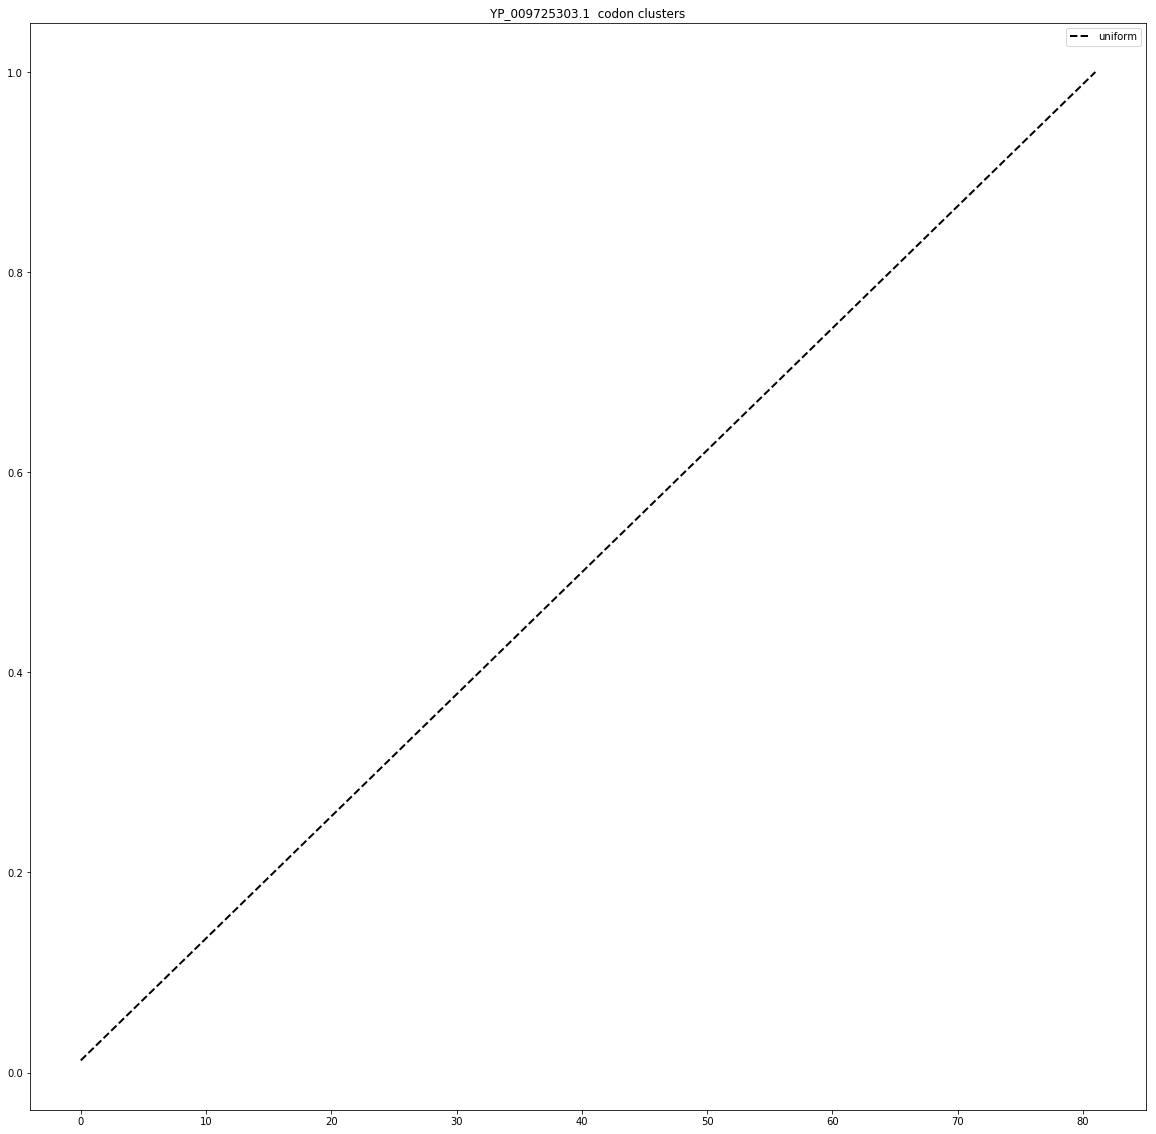

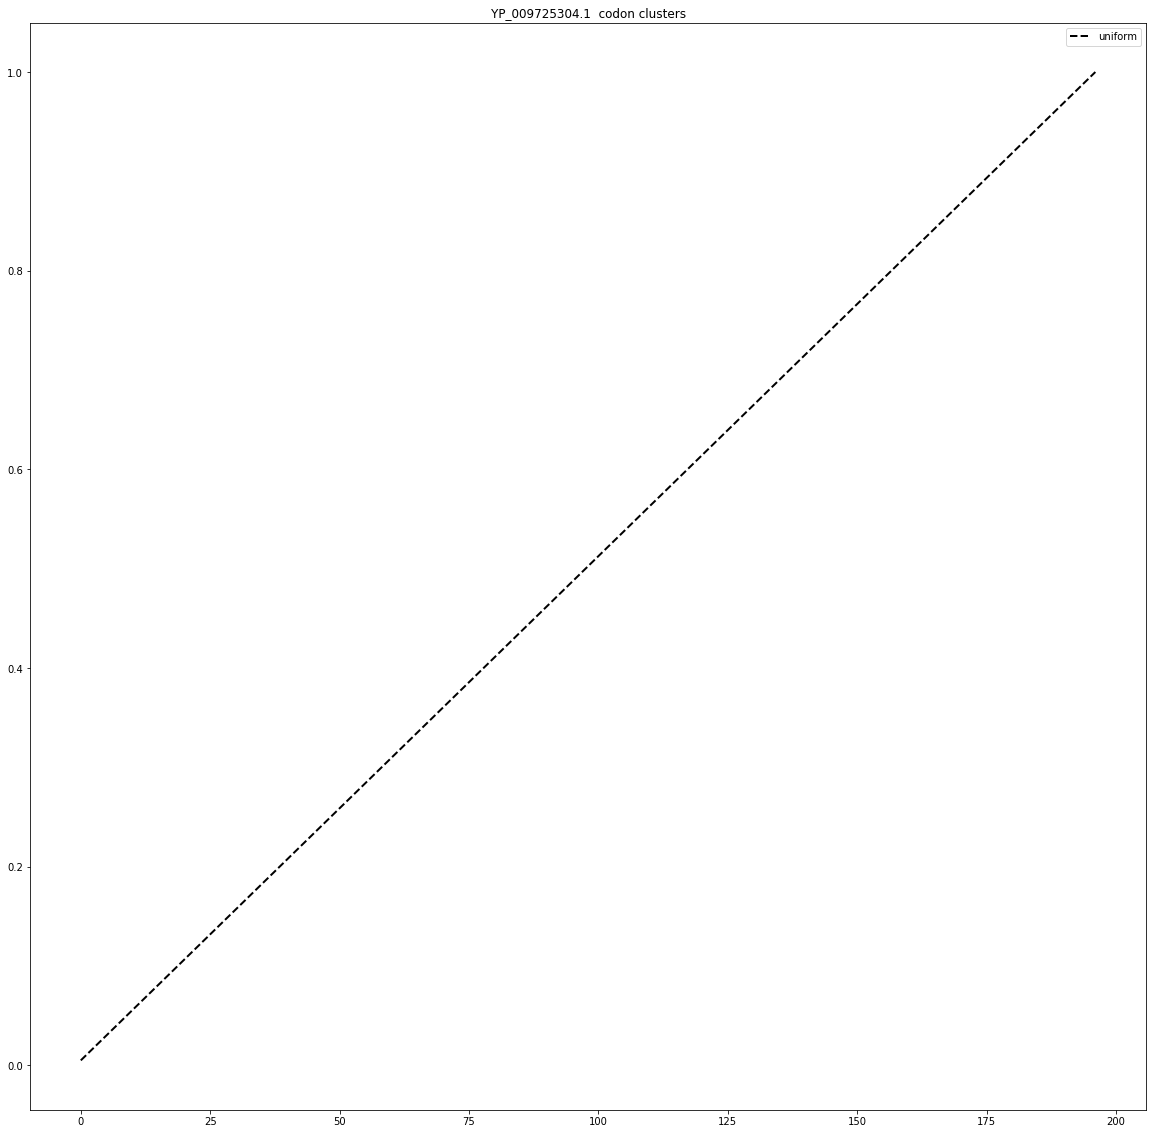

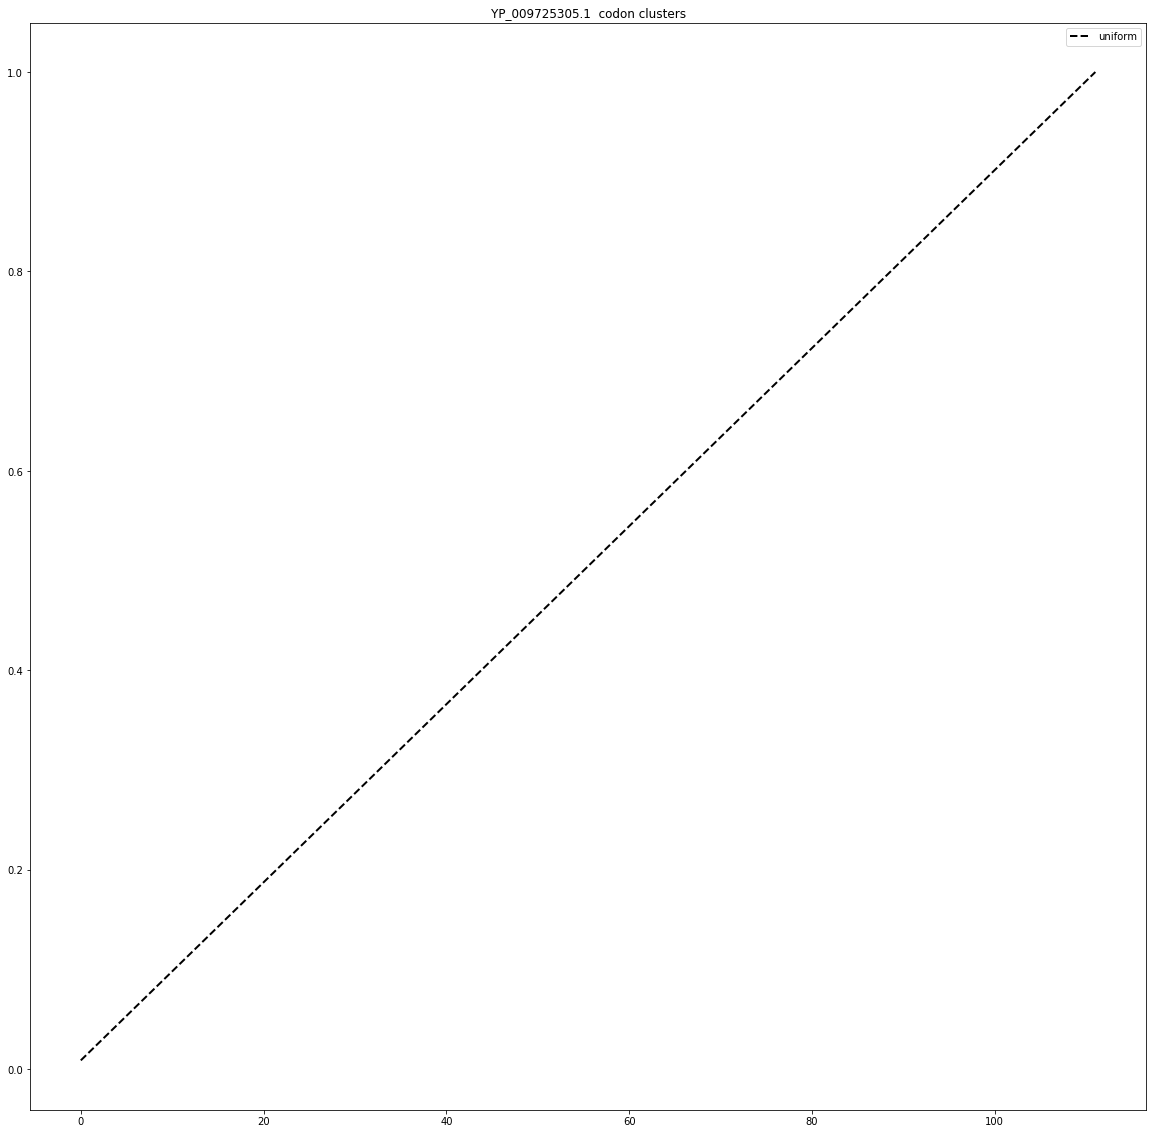

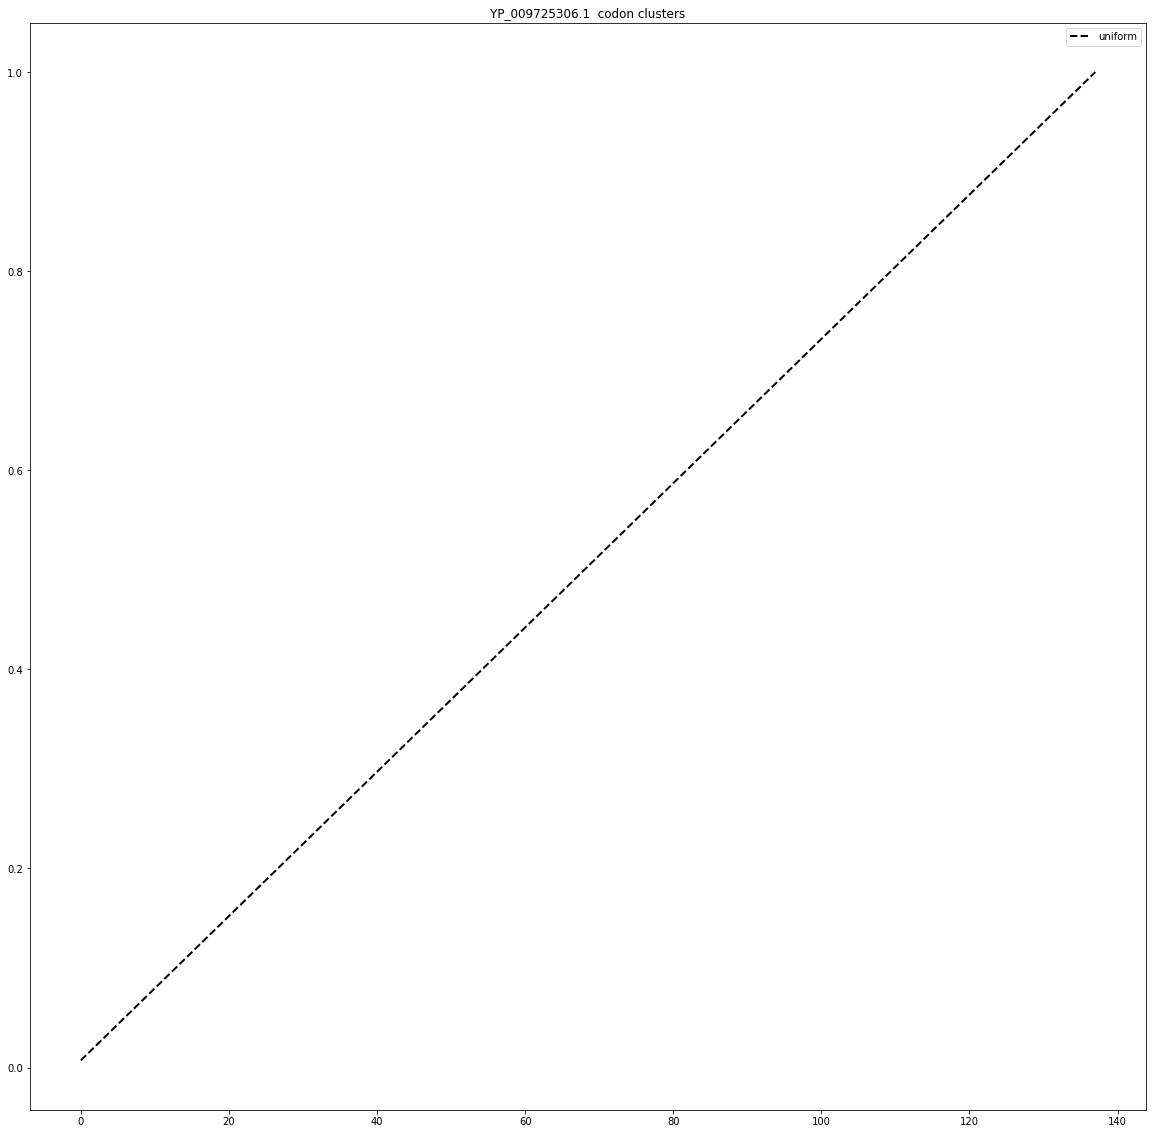

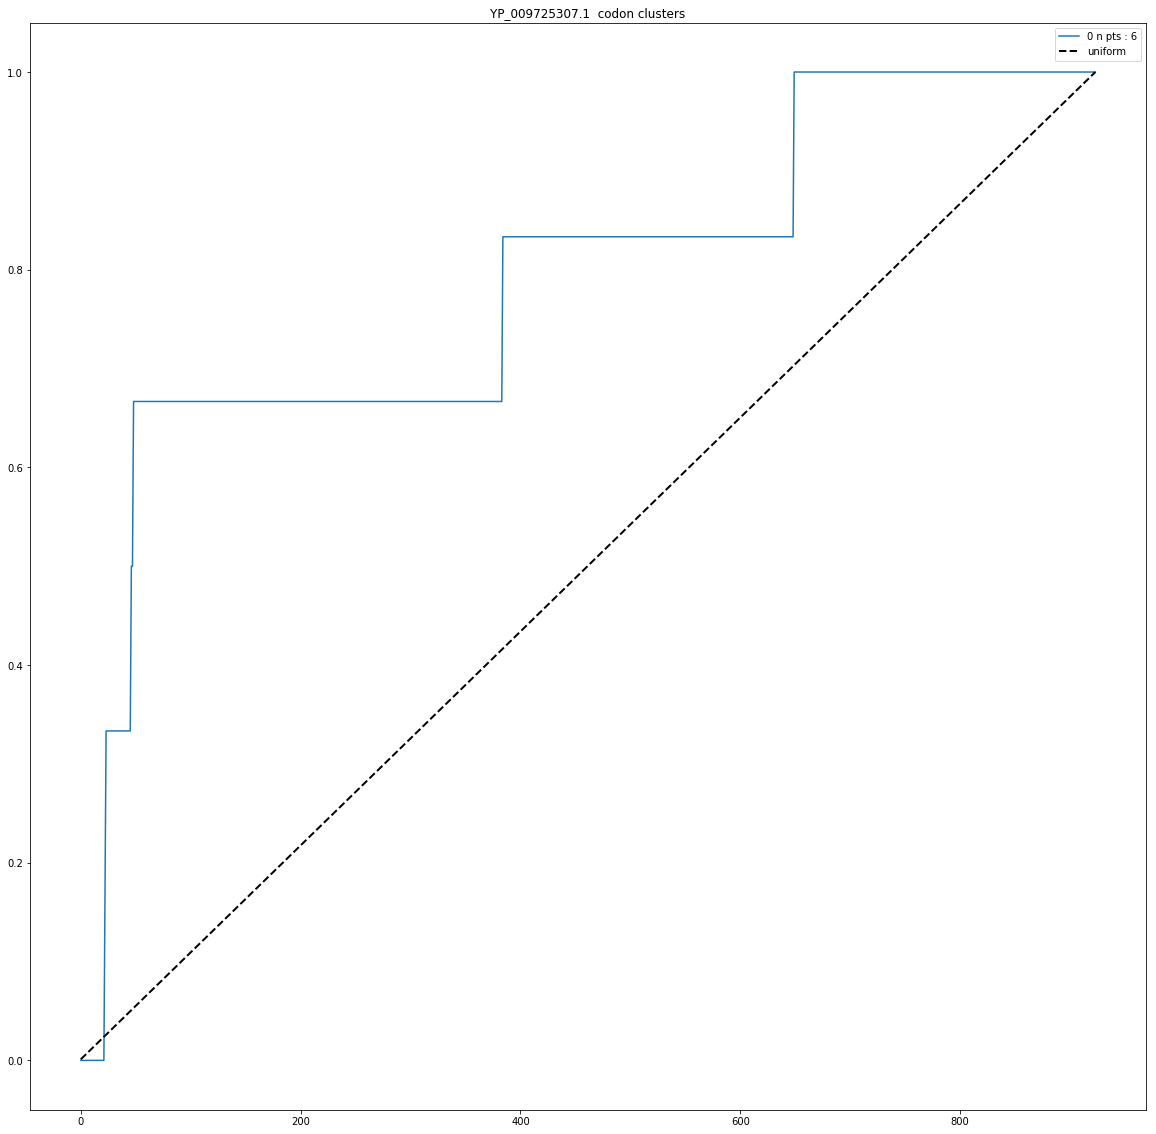

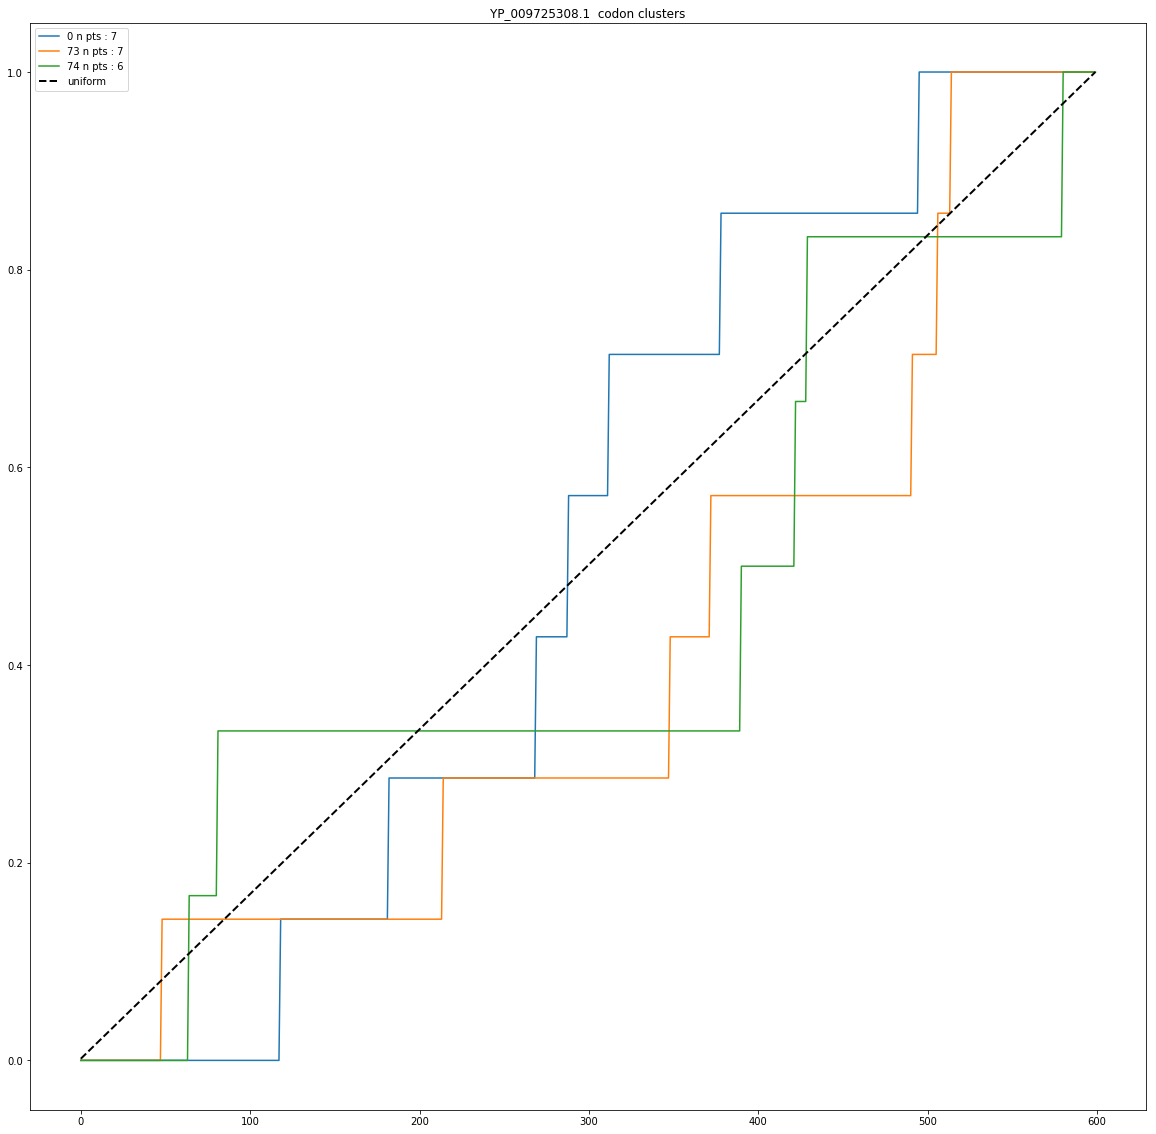

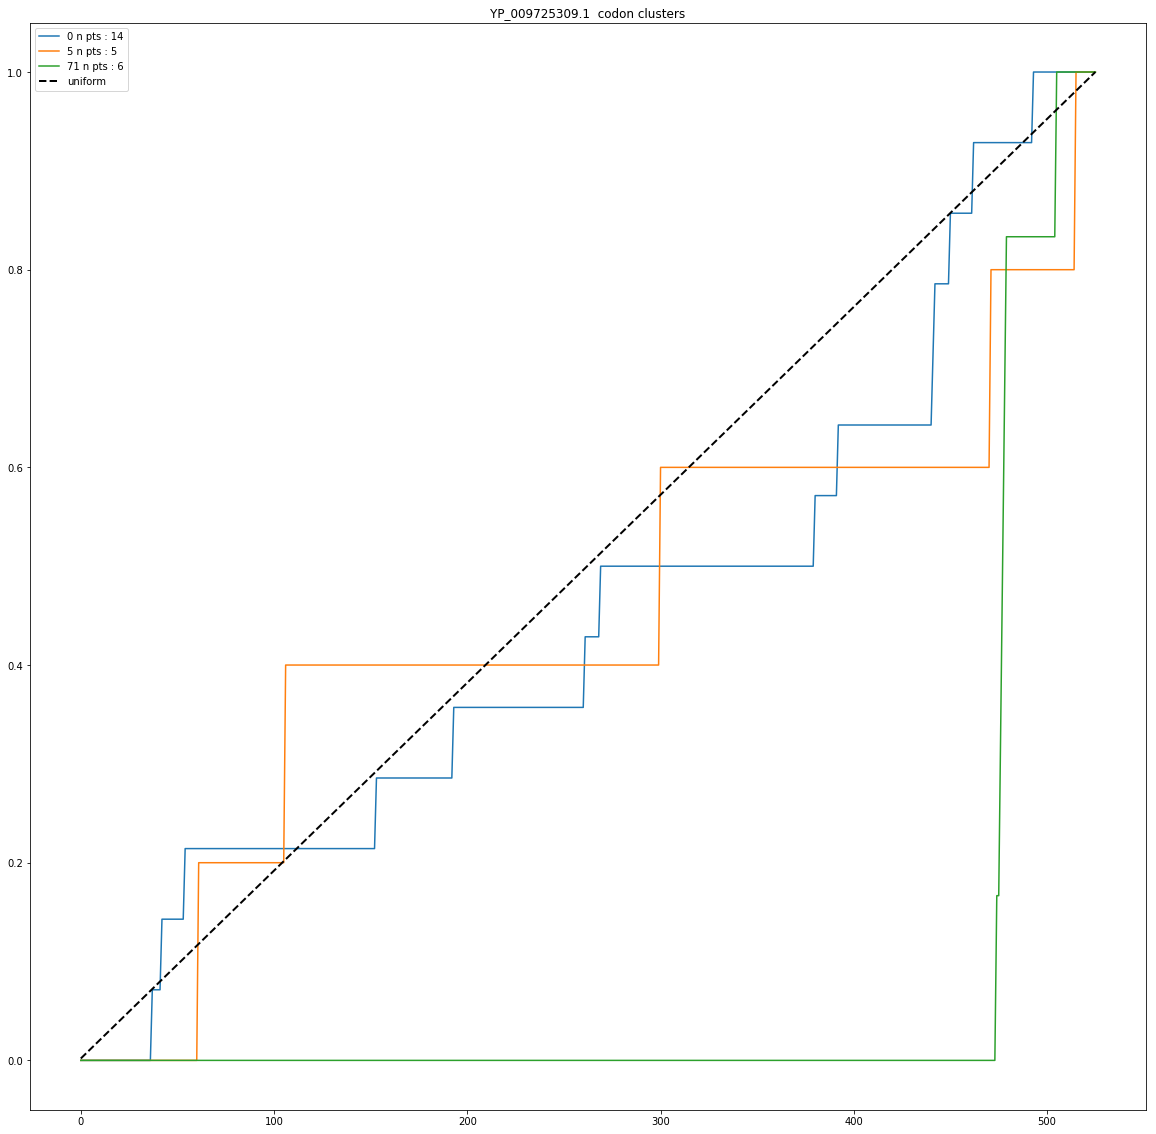

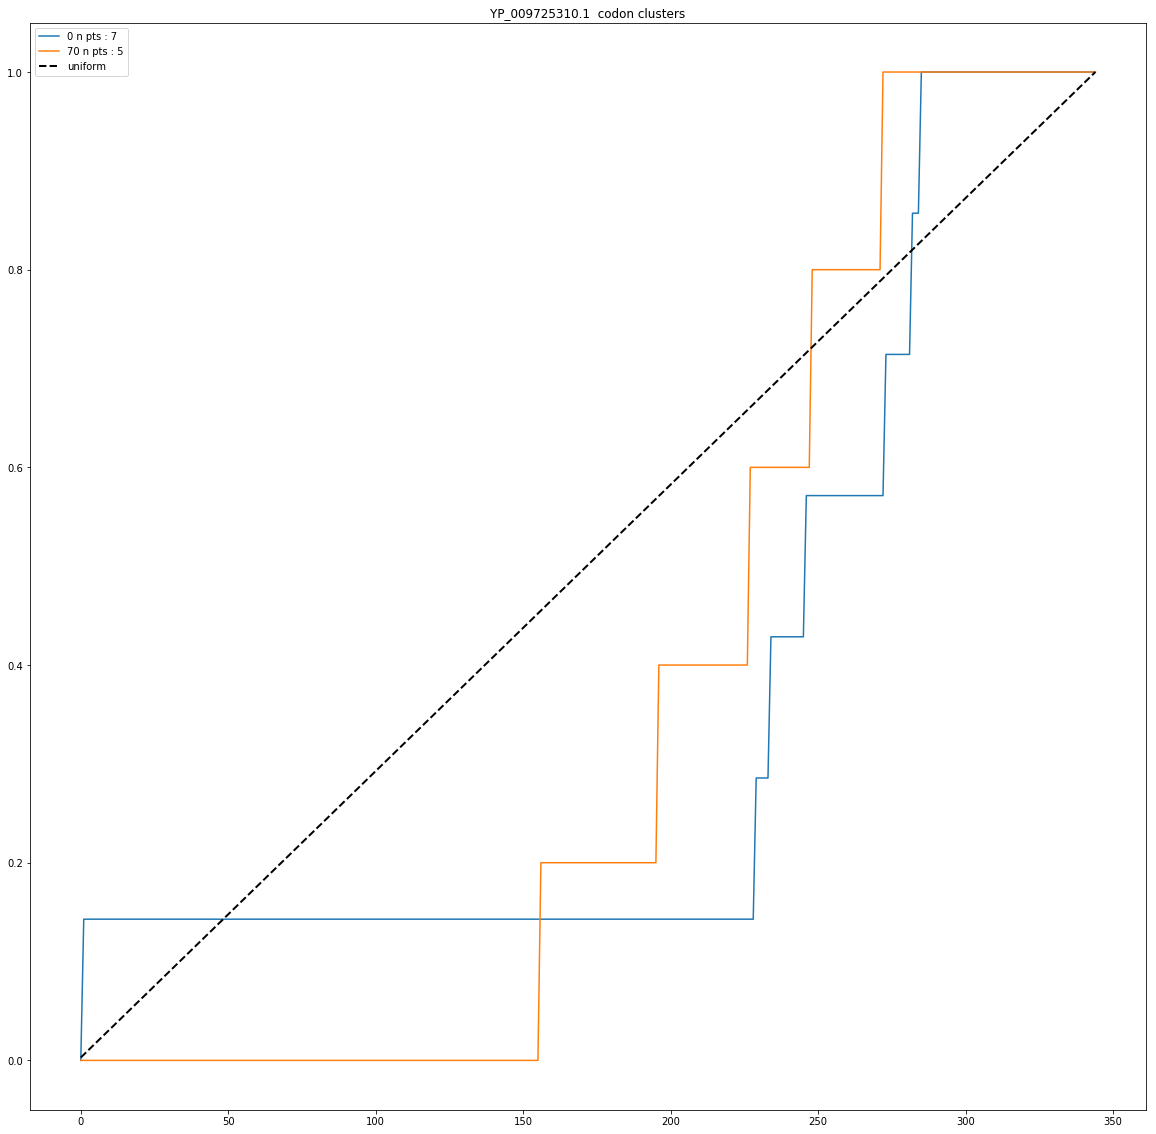

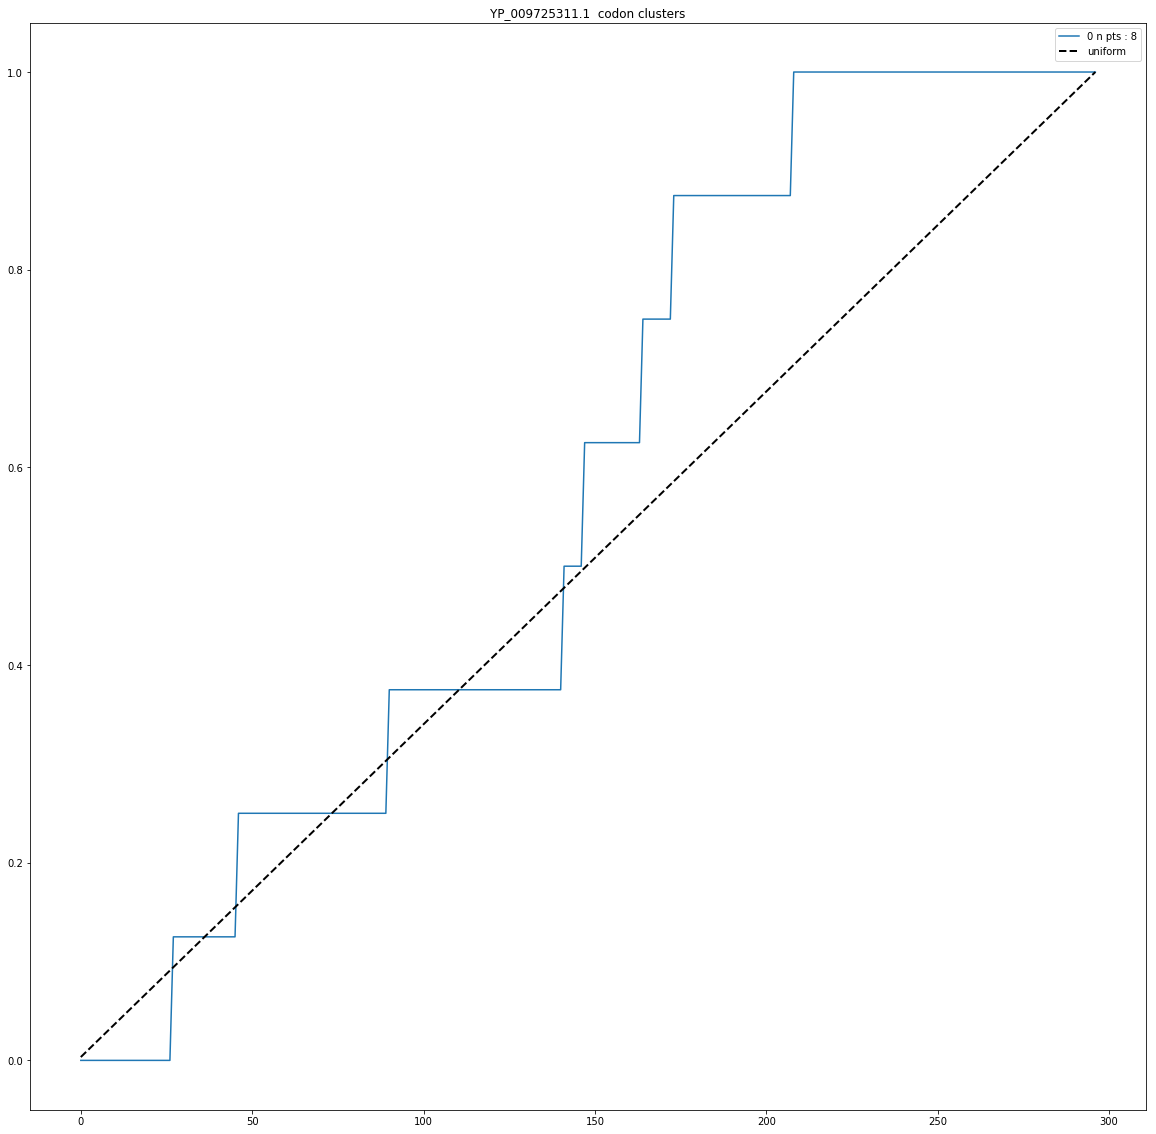

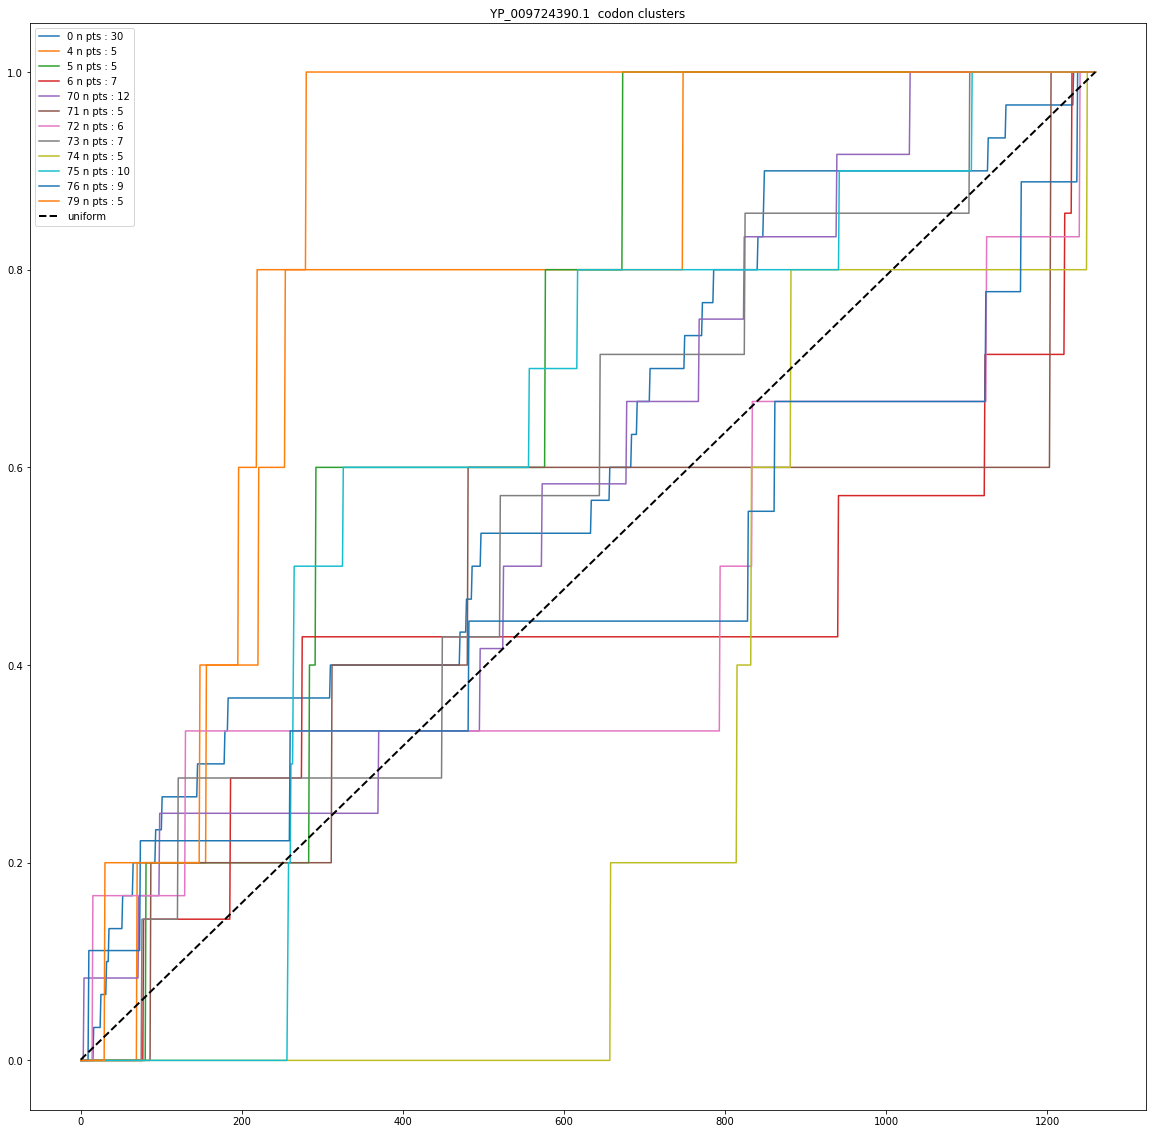

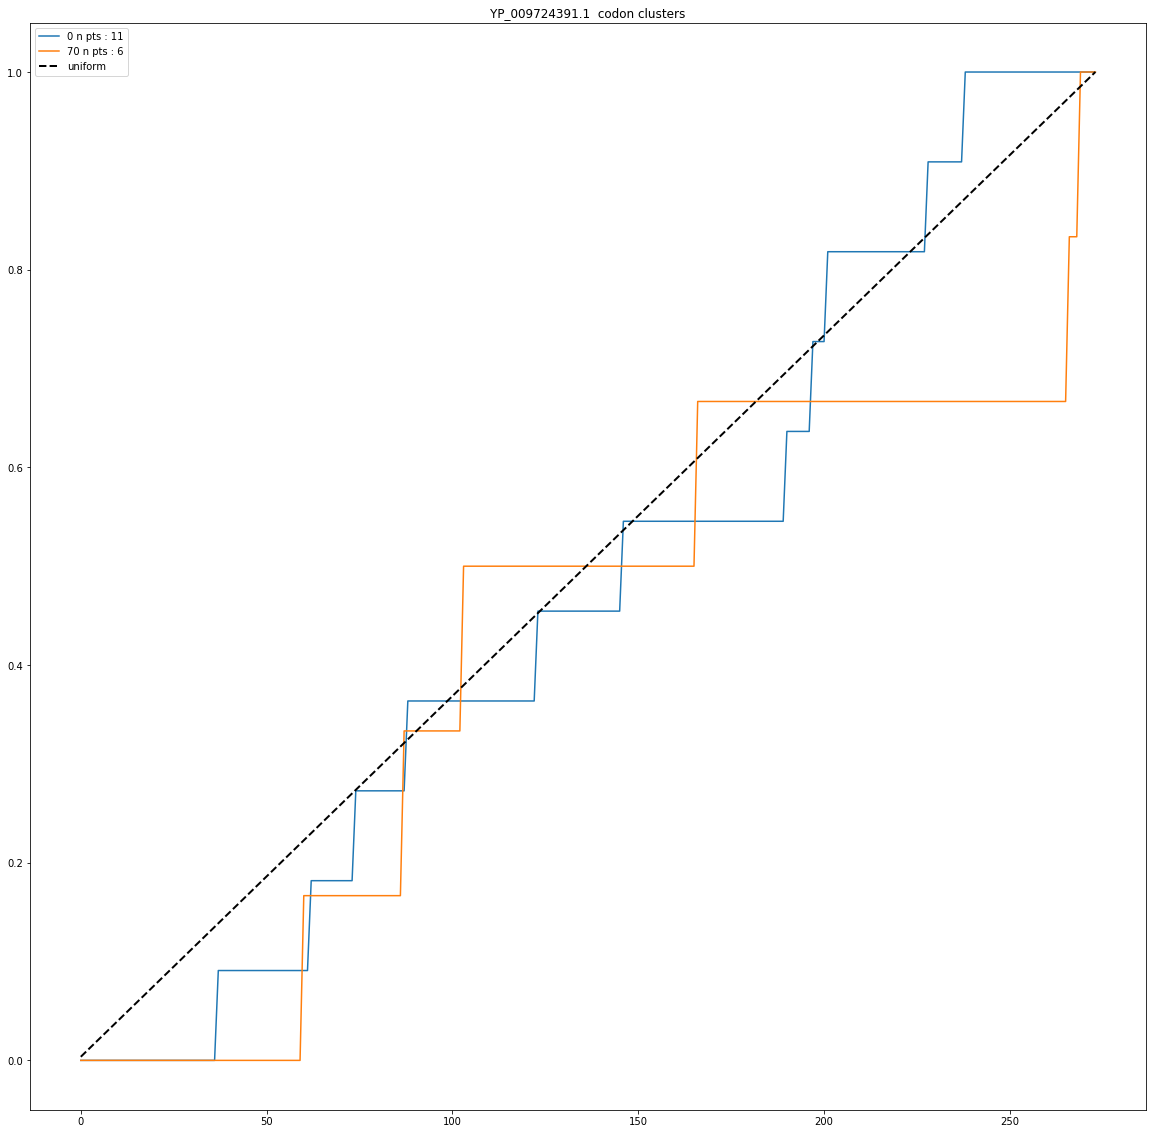

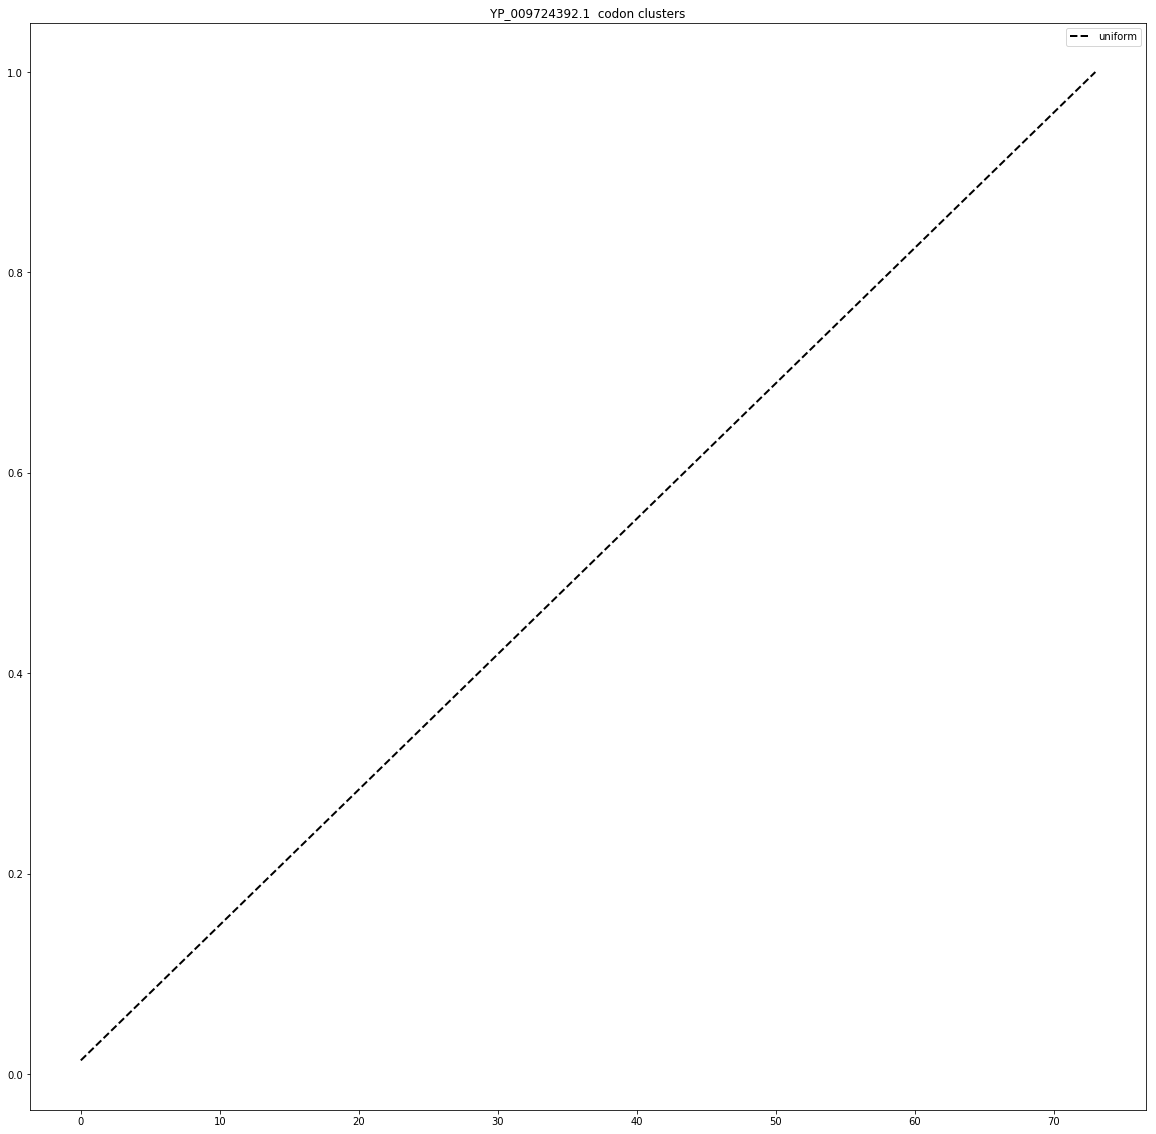

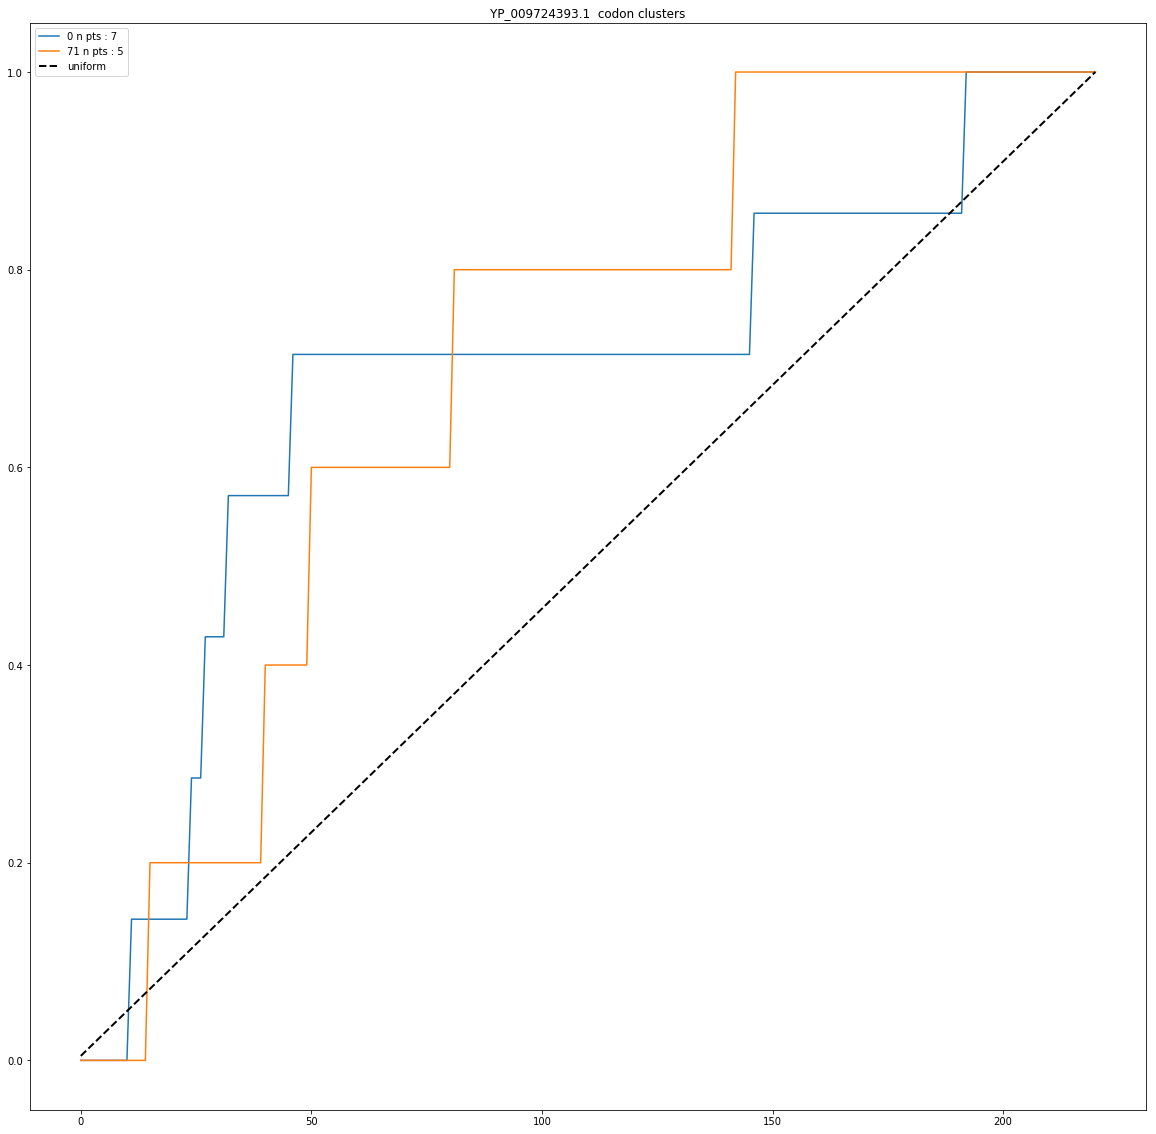

0
(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True]), array([2.35634820e-10, 7.99825678e-43, 7.29200426e-68, 1.01846378e-19,
       0.00000000e+00, 1.31293657e-26, 2.91433274e-22, 1.51034600e-86,
       4.55093803e-23, 2.28985226e-56, 1.27170390e-04, 6.84425222e-52]), 0.004265318777560645, 0.004166666666666667)
3
(array([ True,  True]), array([2.96461368e-47, 1.01520052e-86]), 0.025320565519103666, 0.025)
10
(array([ True,  True]), array([8.16587081e-196, 7.68569485e-117]), 0.025320565519103666, 0.025)
70
(array([ True,  True,  True,  True,  True]), array([2.36299231e-109, 4.50336386e-213, 3.13502833e-064, 8.28545364e-037,
       2.74006640e-022]), 0.010206218313011495, 0.01)
72
(array([ True,  True,  True]), array([5.79965785e-86, 2.02715777e-92, 3.64050791e-98]), 0.016952427508441503, 0.016666666666666666)
73
(array([ True,  True,  True,  True]), array([1.93366693e-053, 1.23369132e-109, 6.13482094e-046, 2.17979114e-045]), 0.01274145509

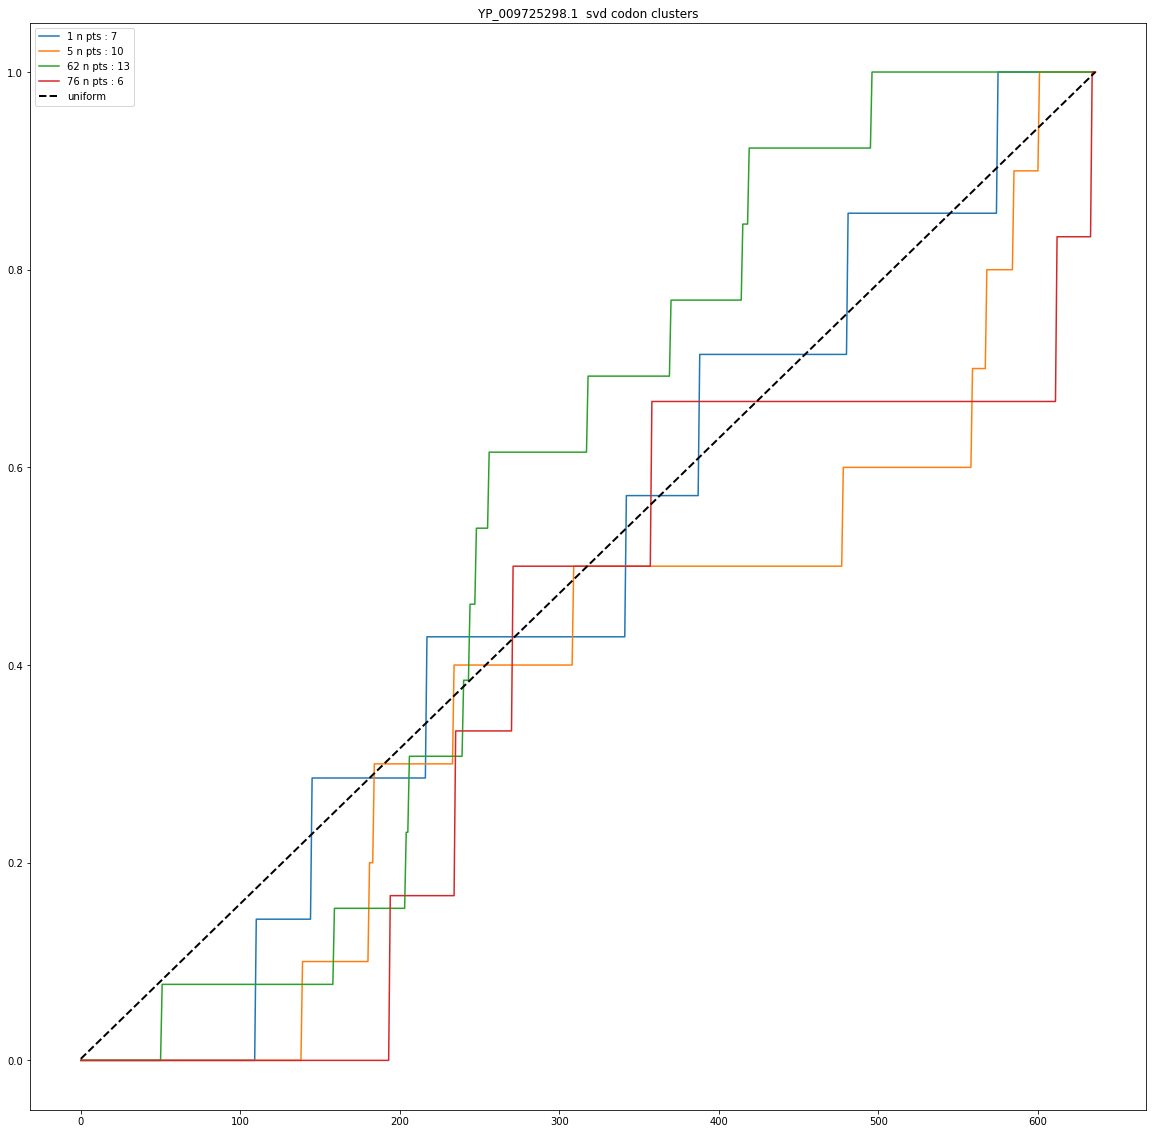

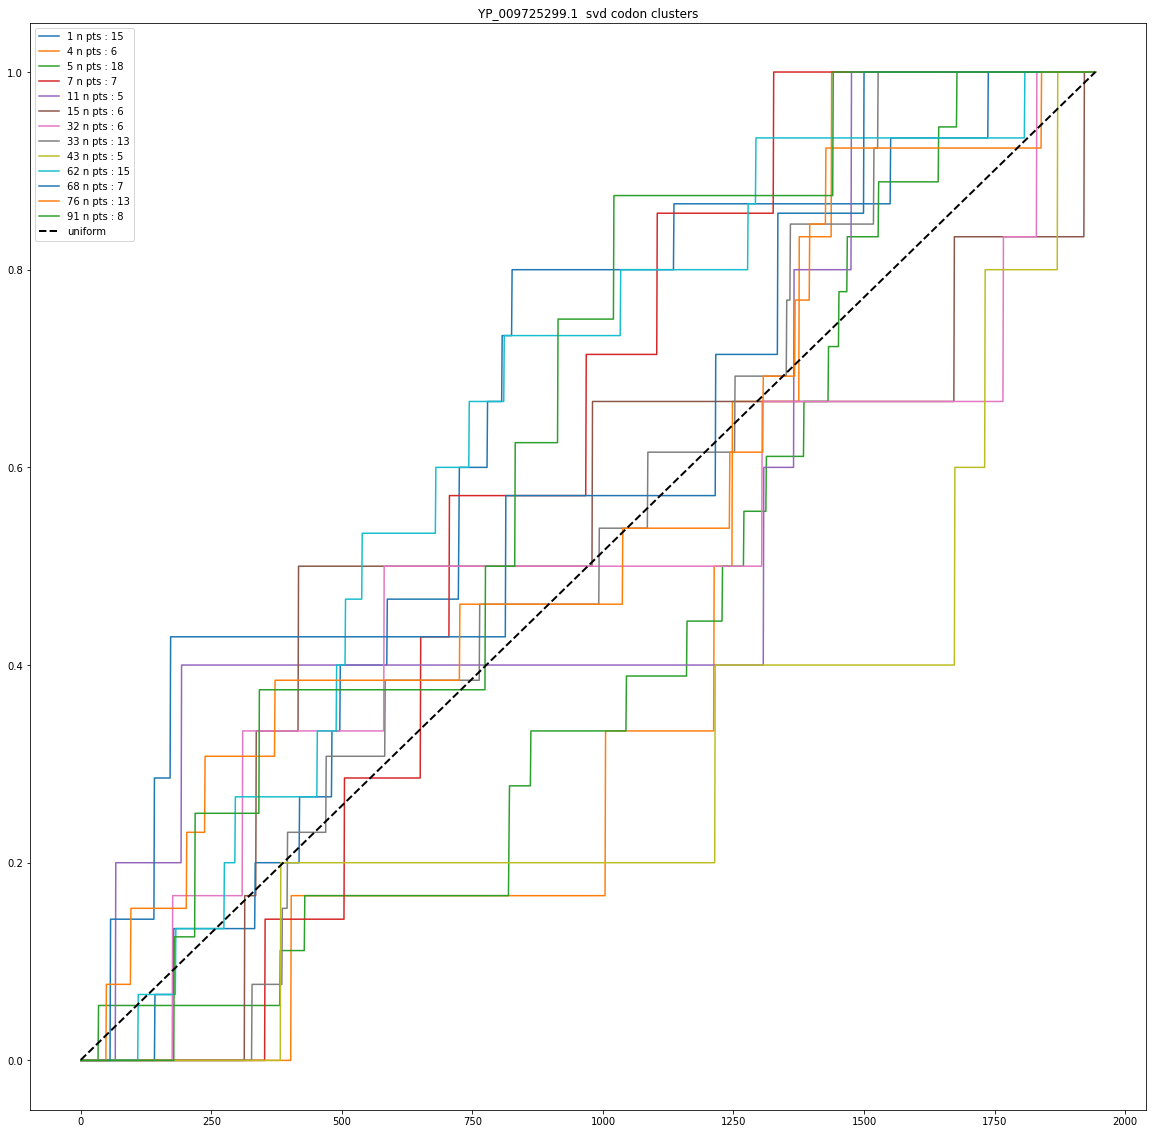

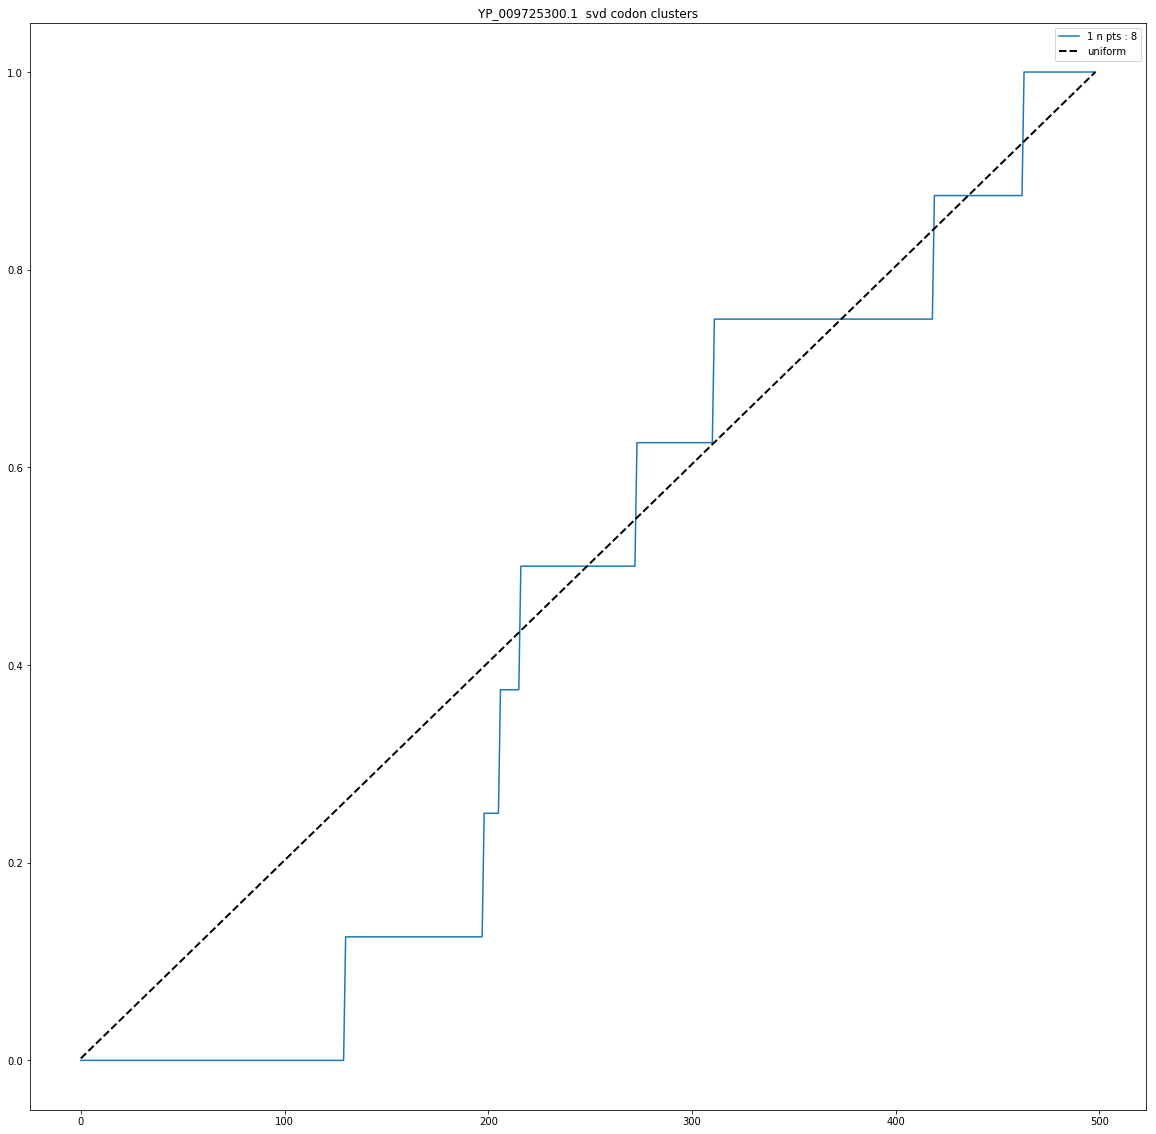

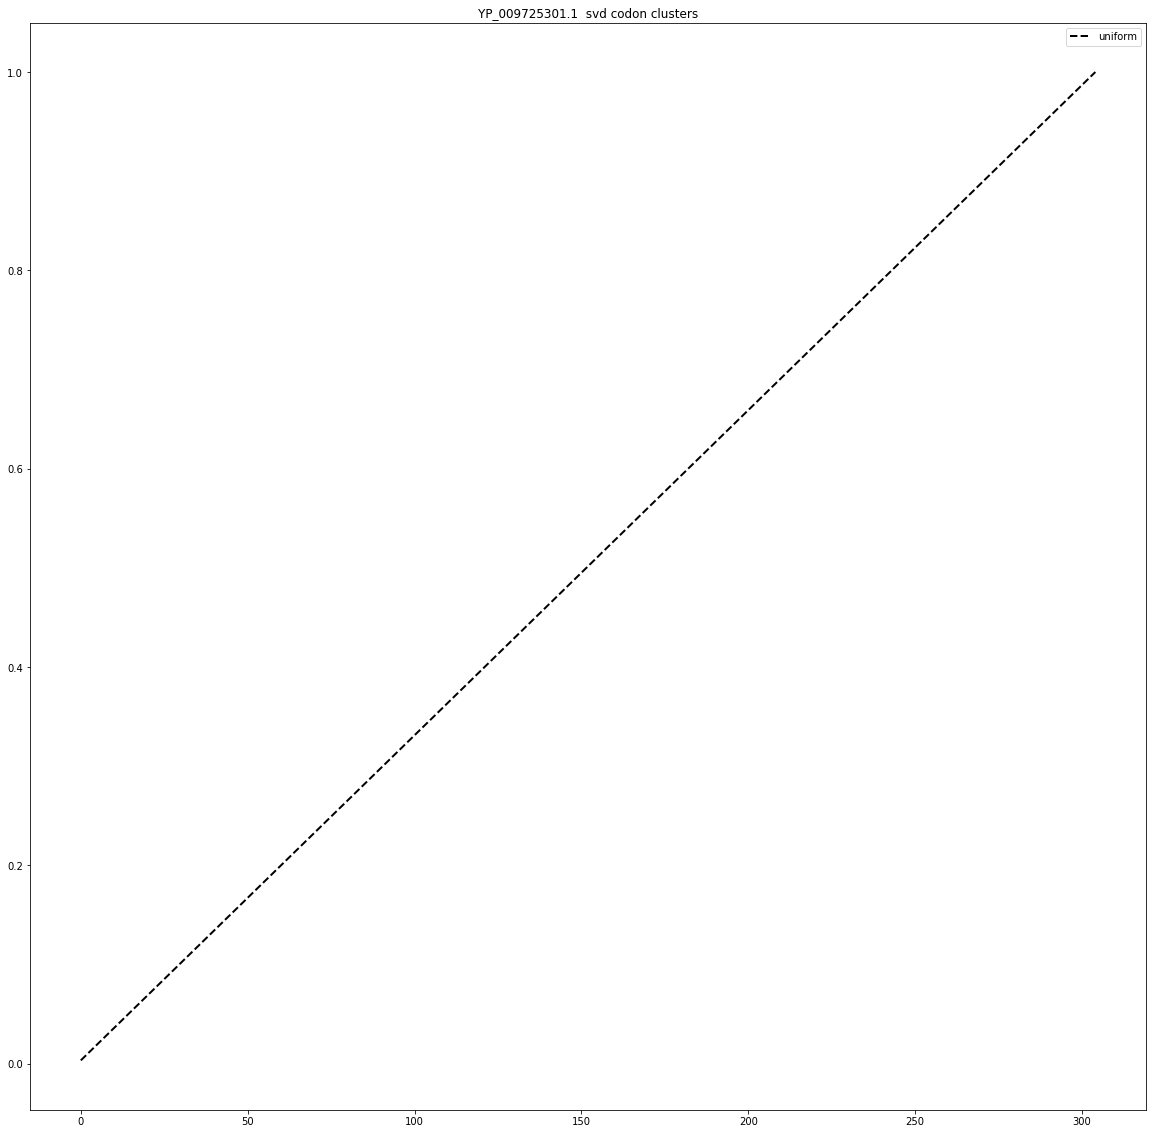

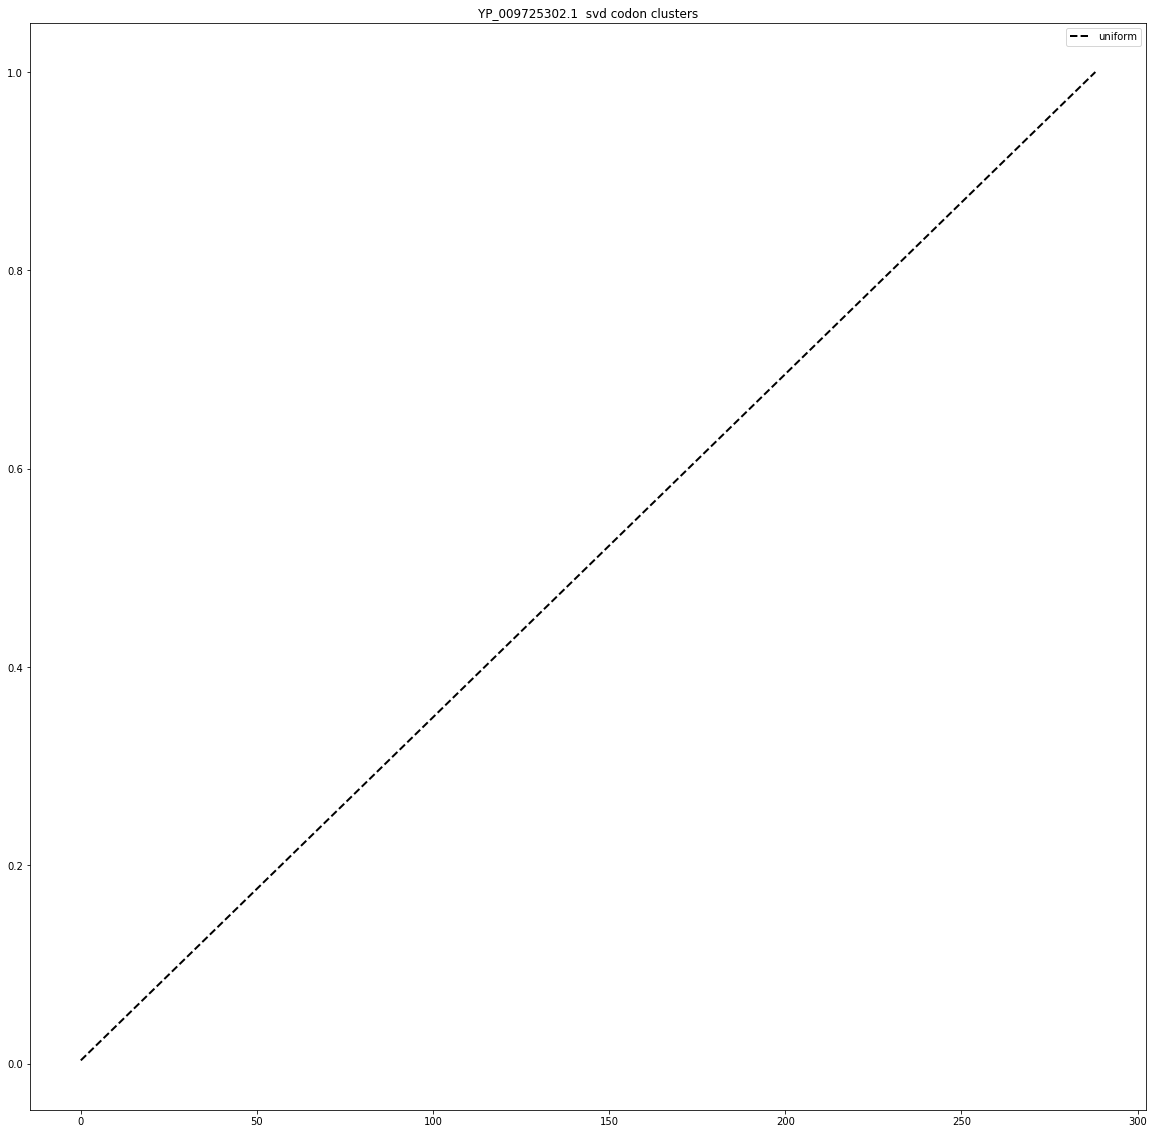

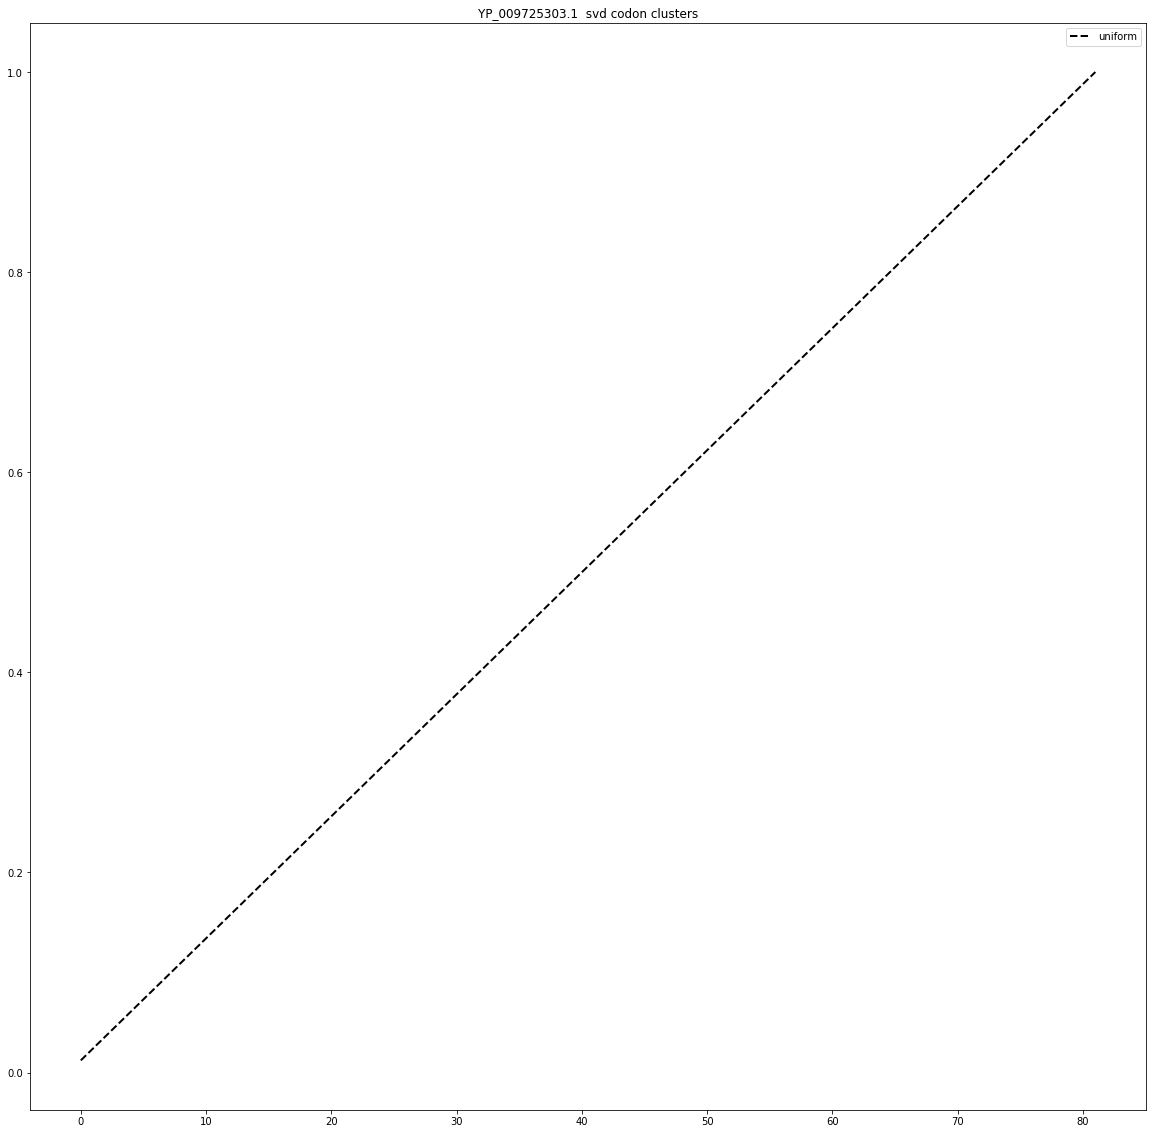

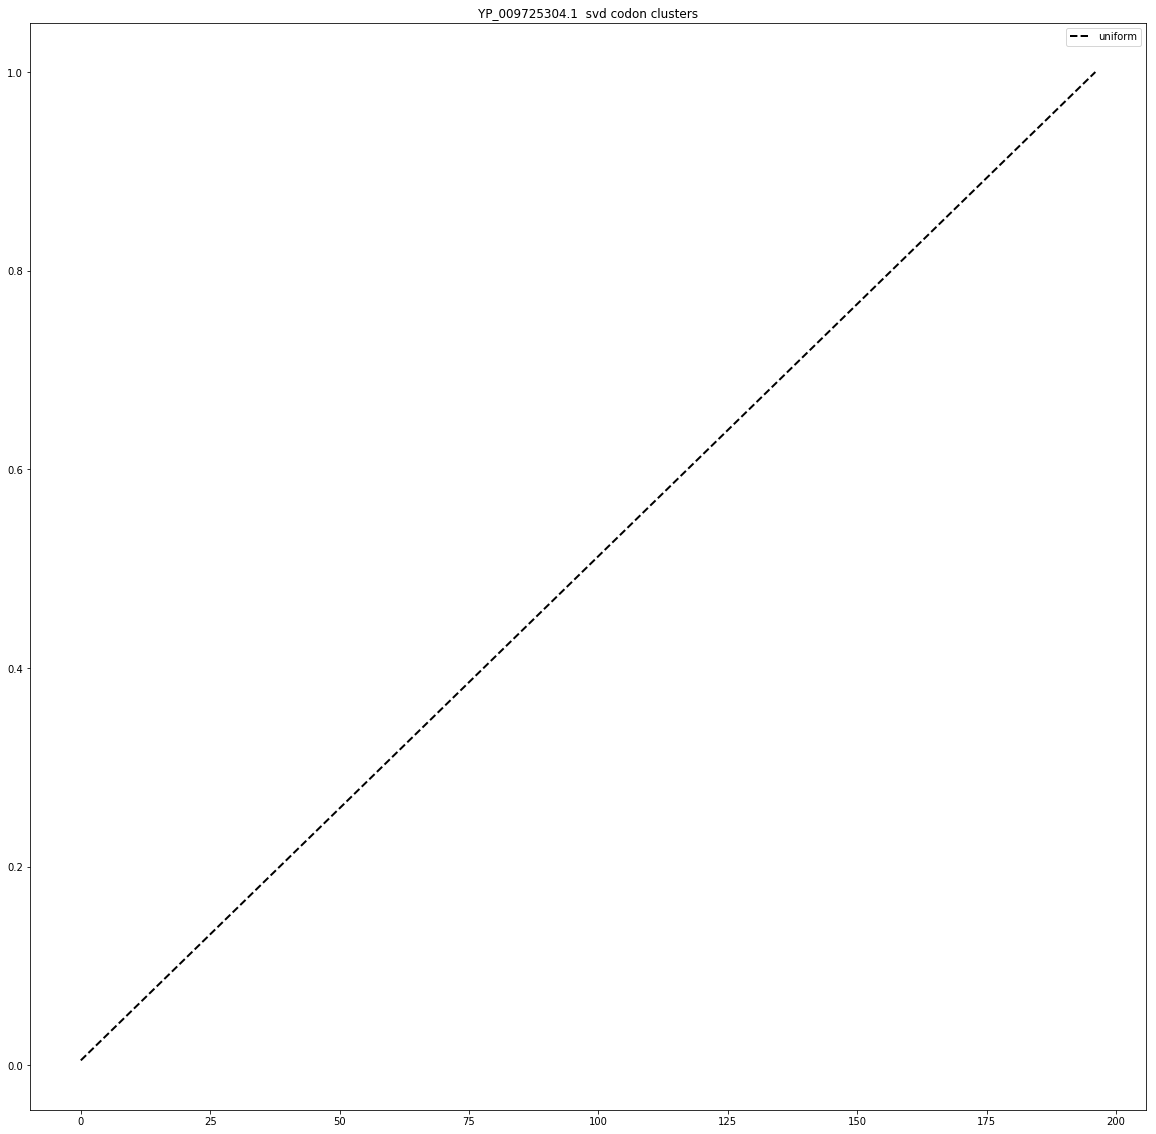

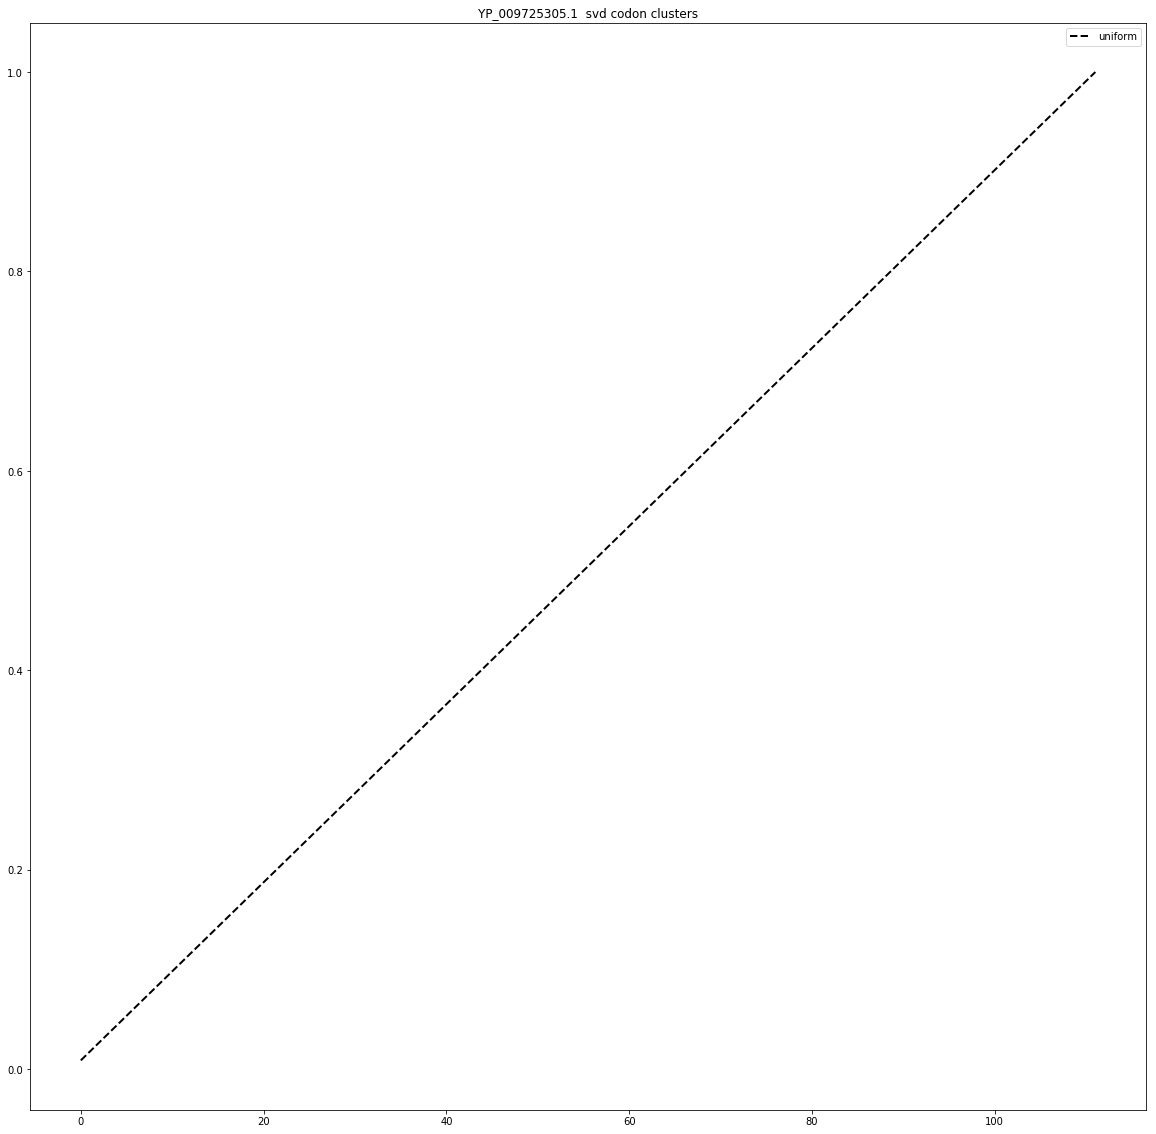

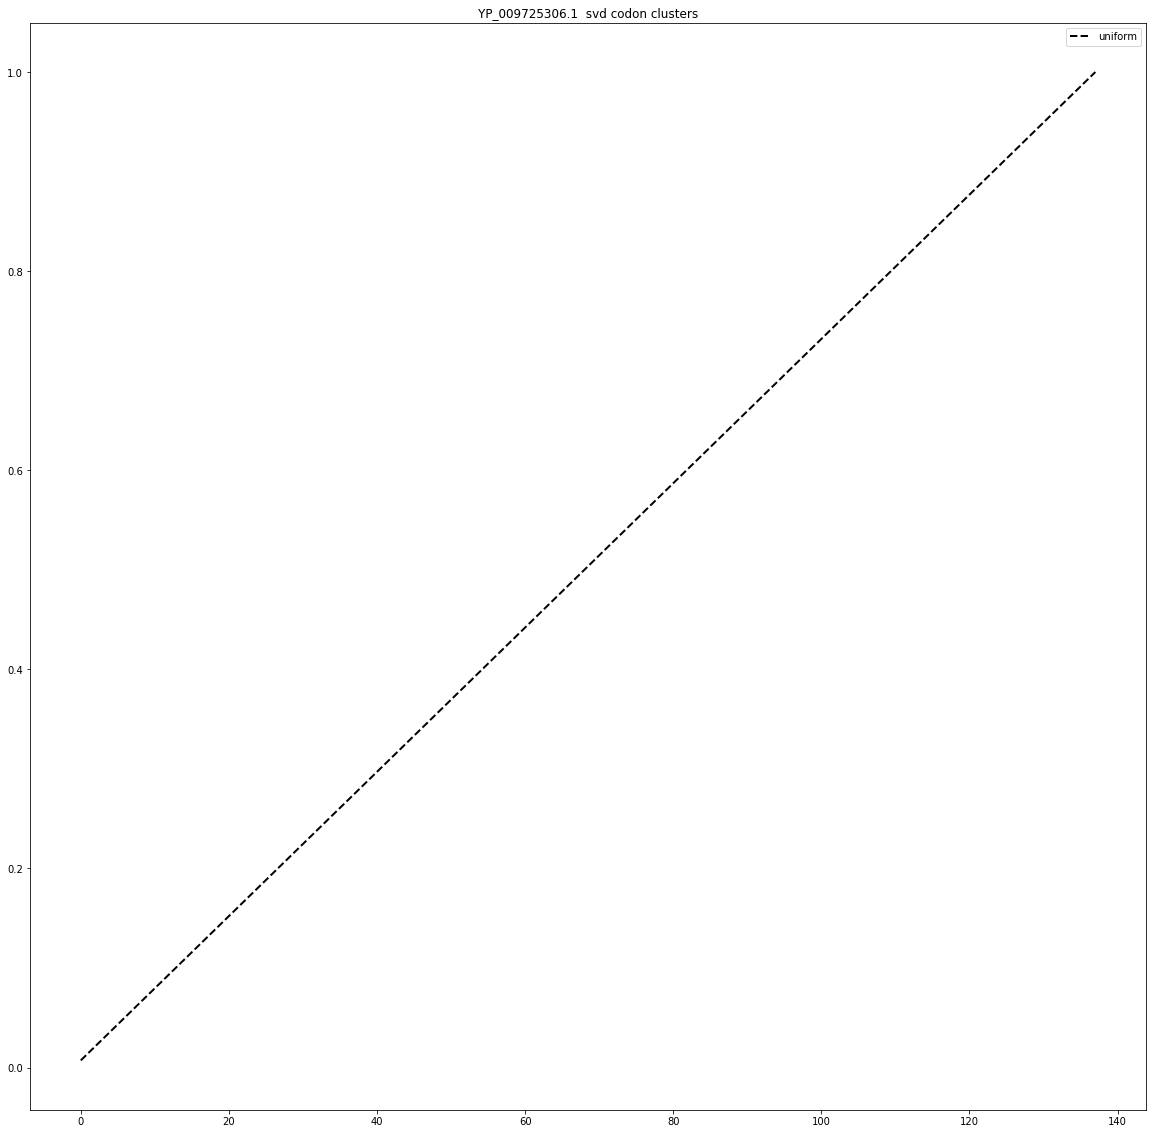

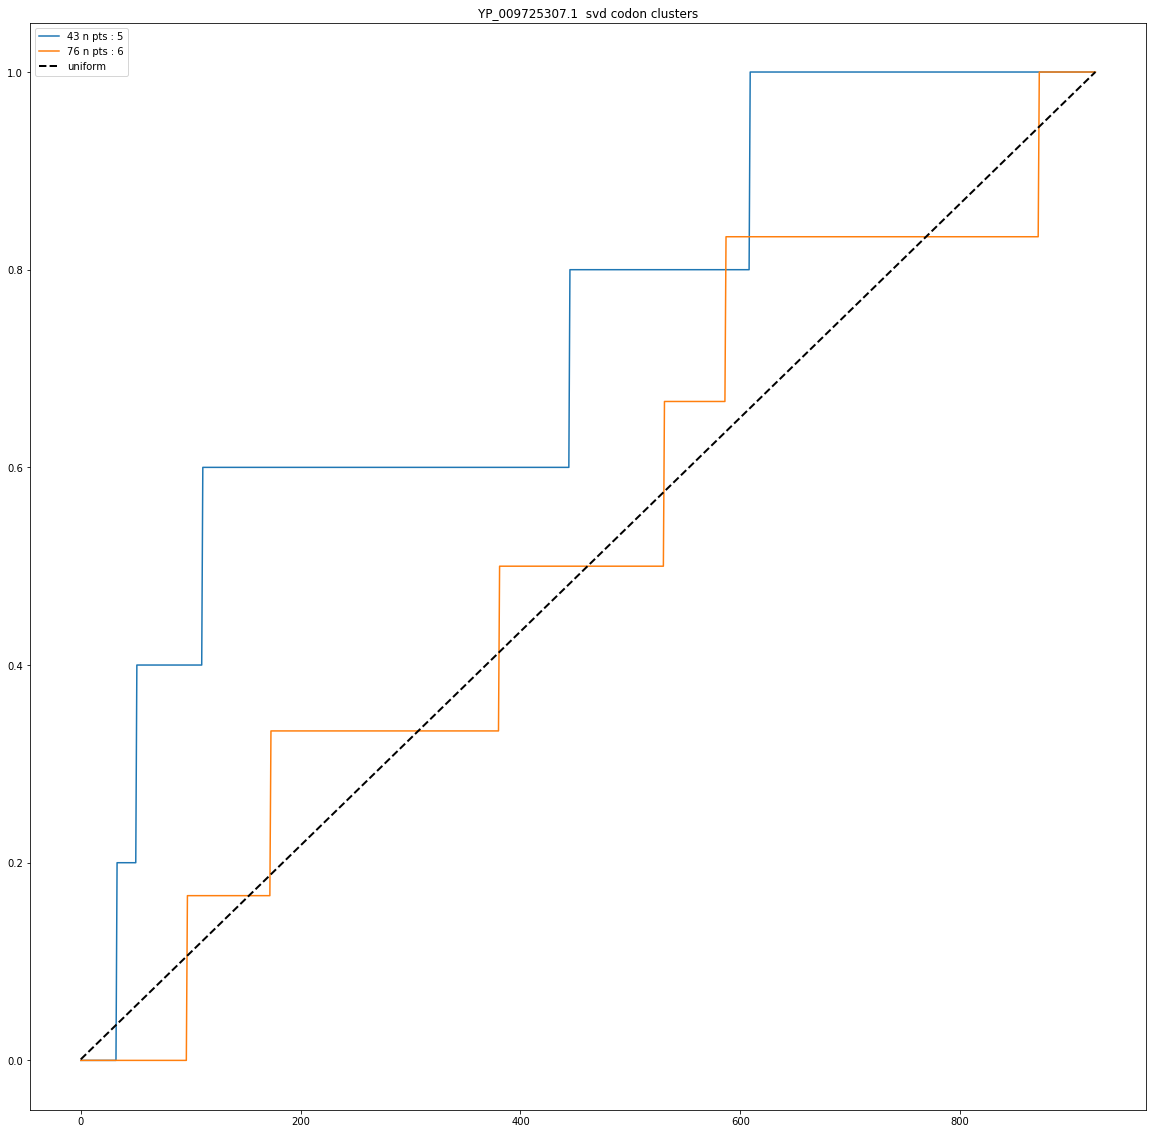

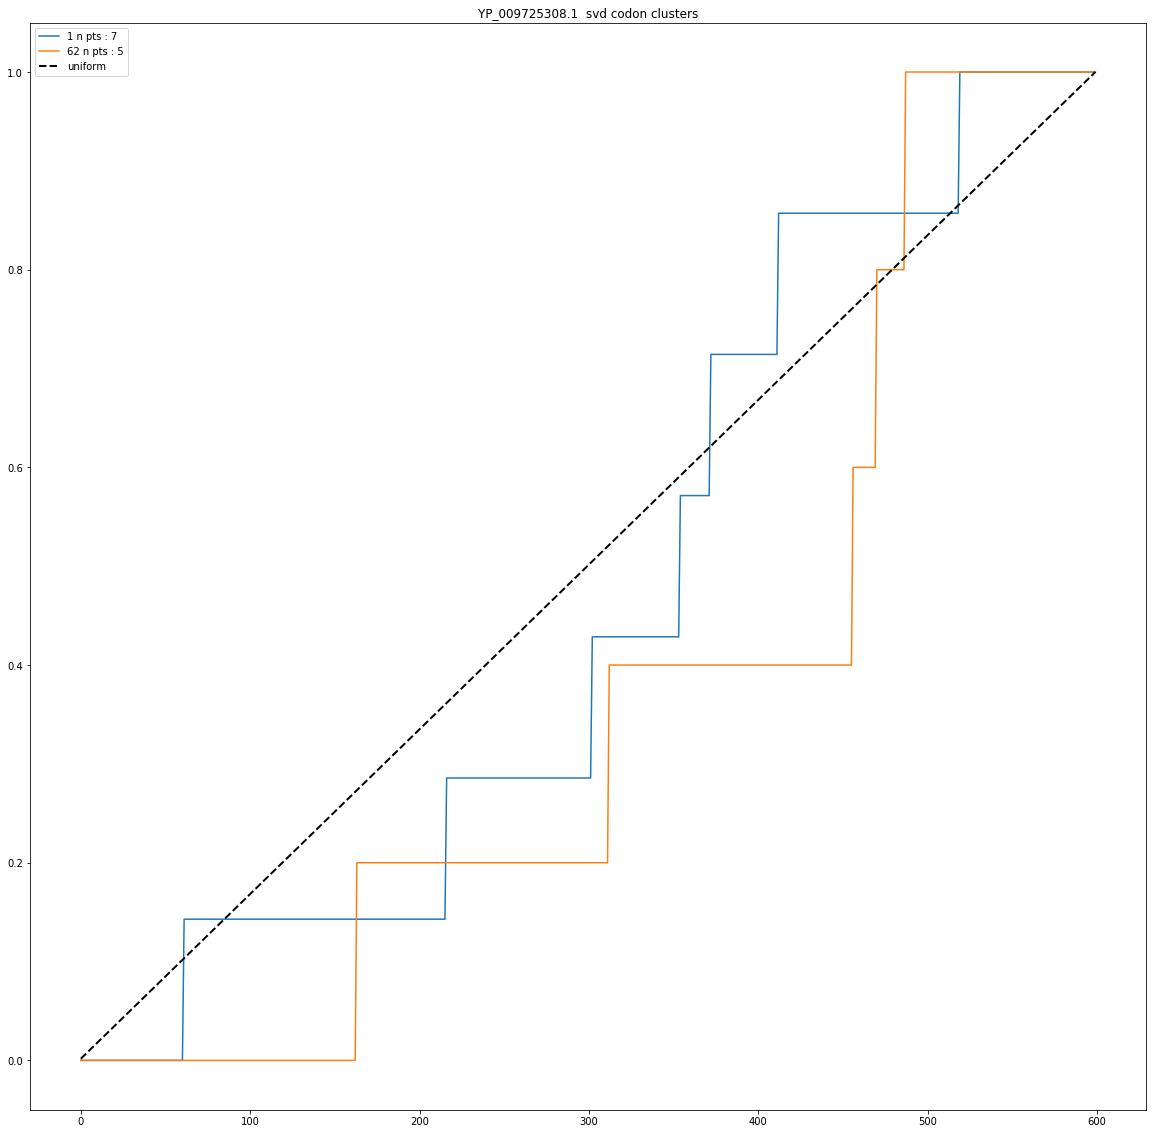

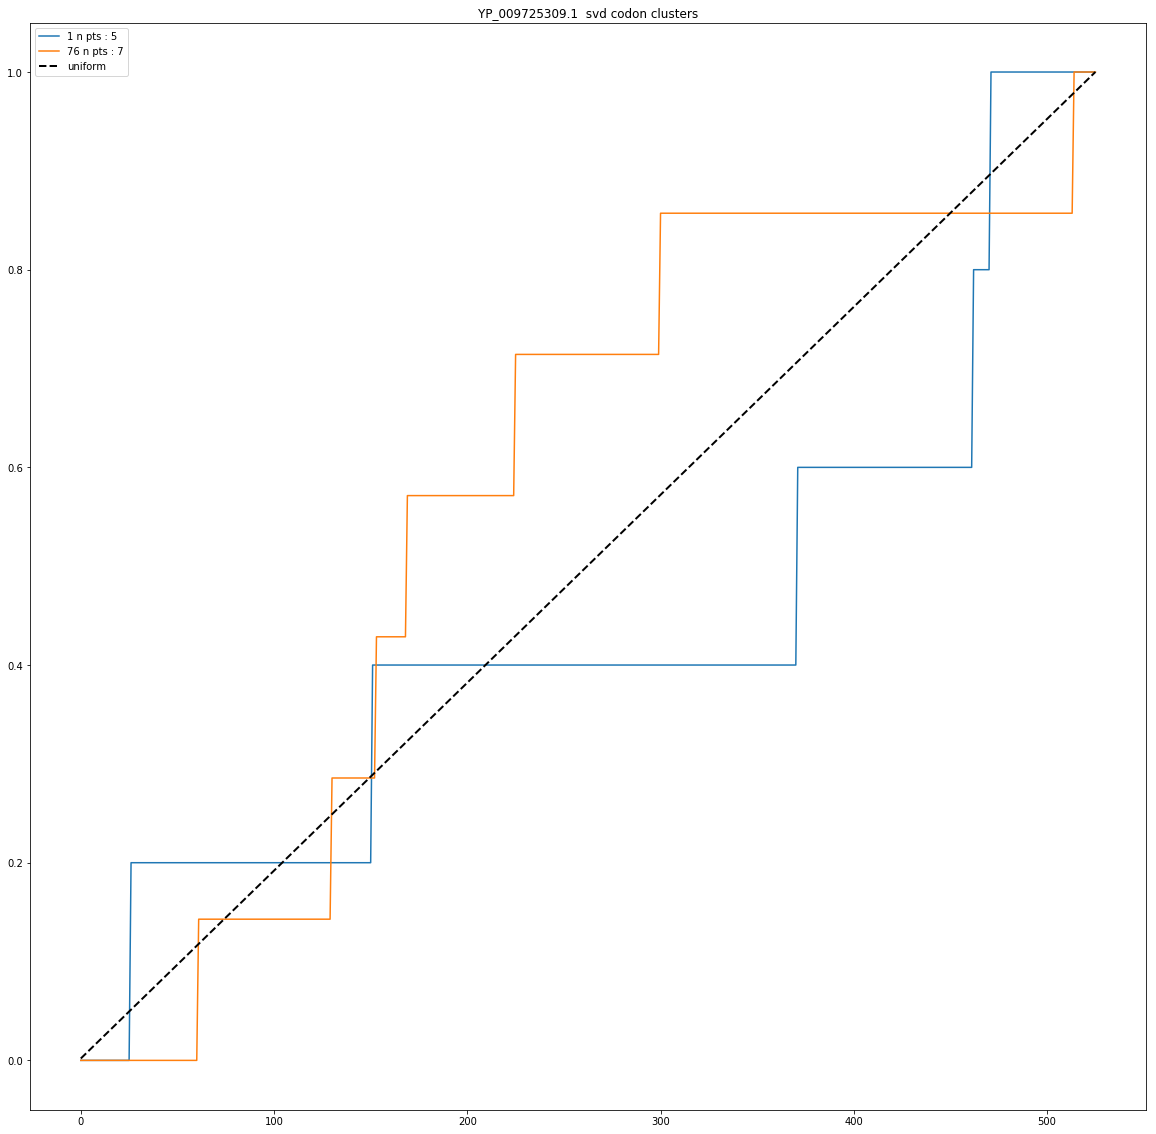

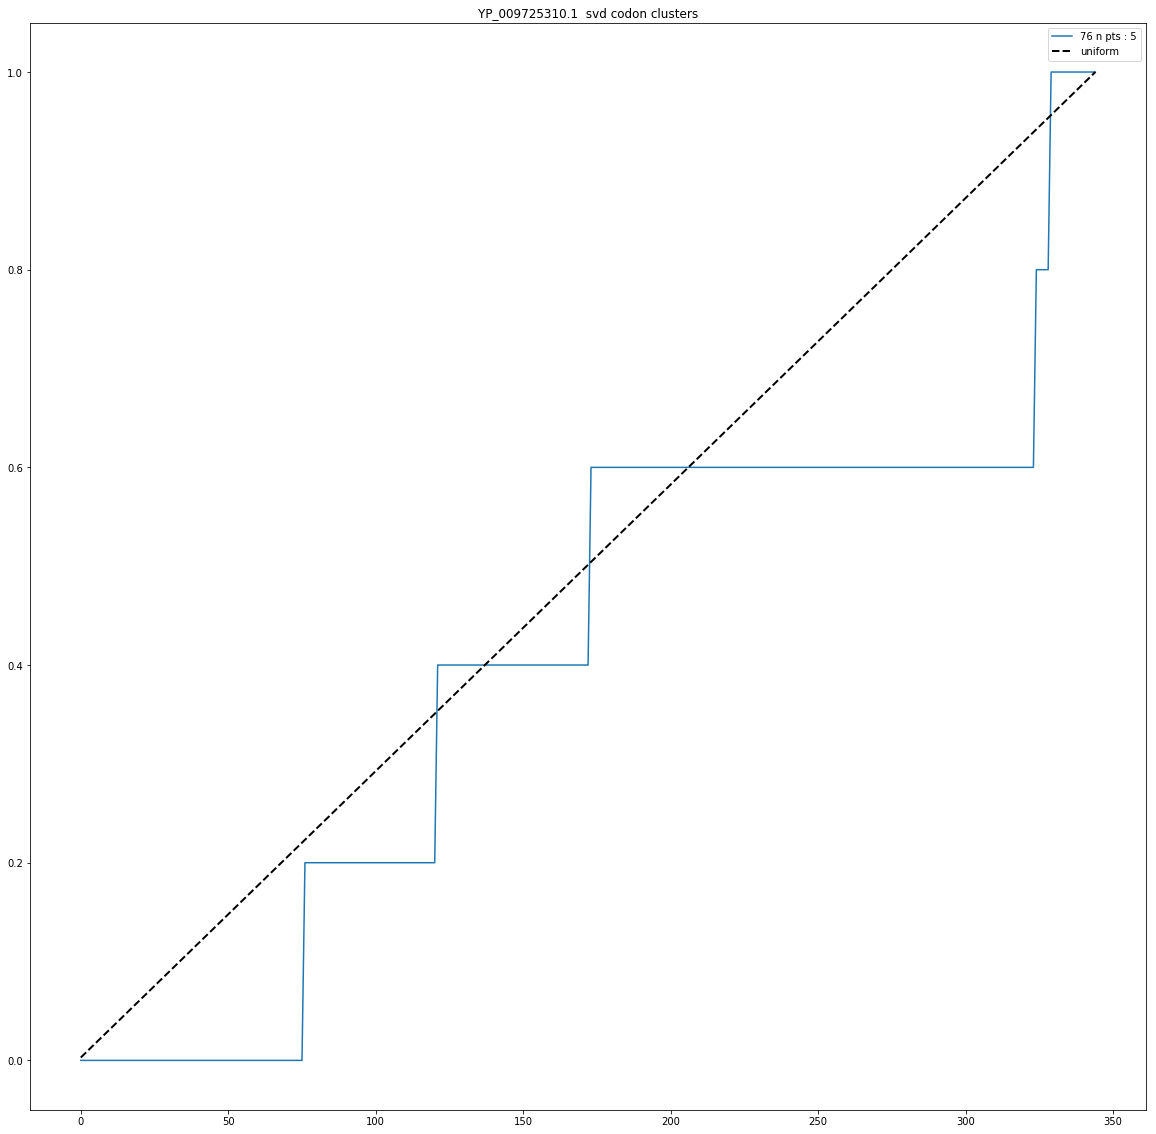

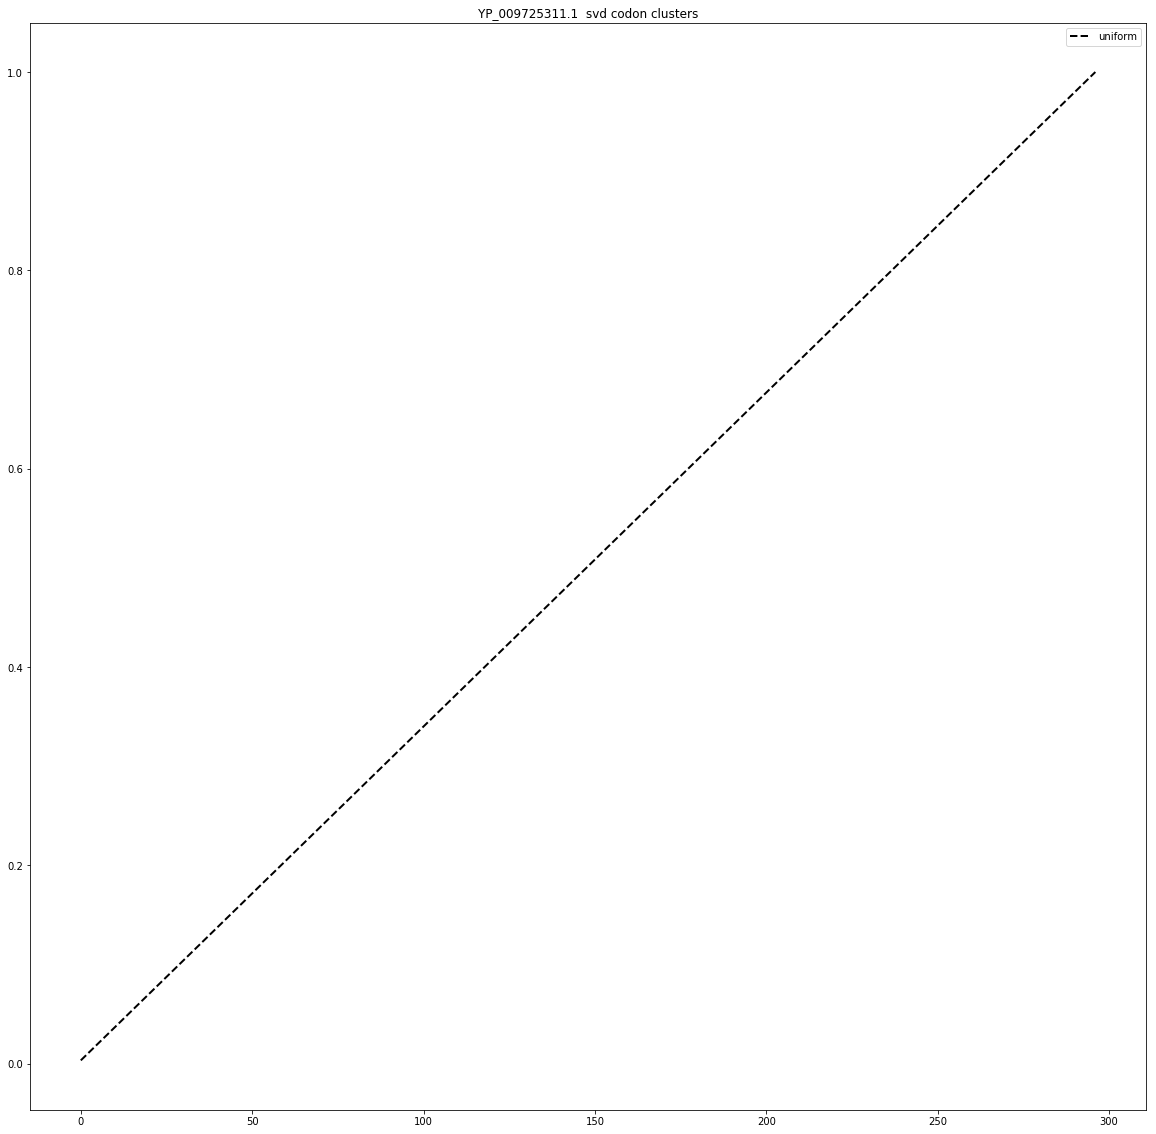

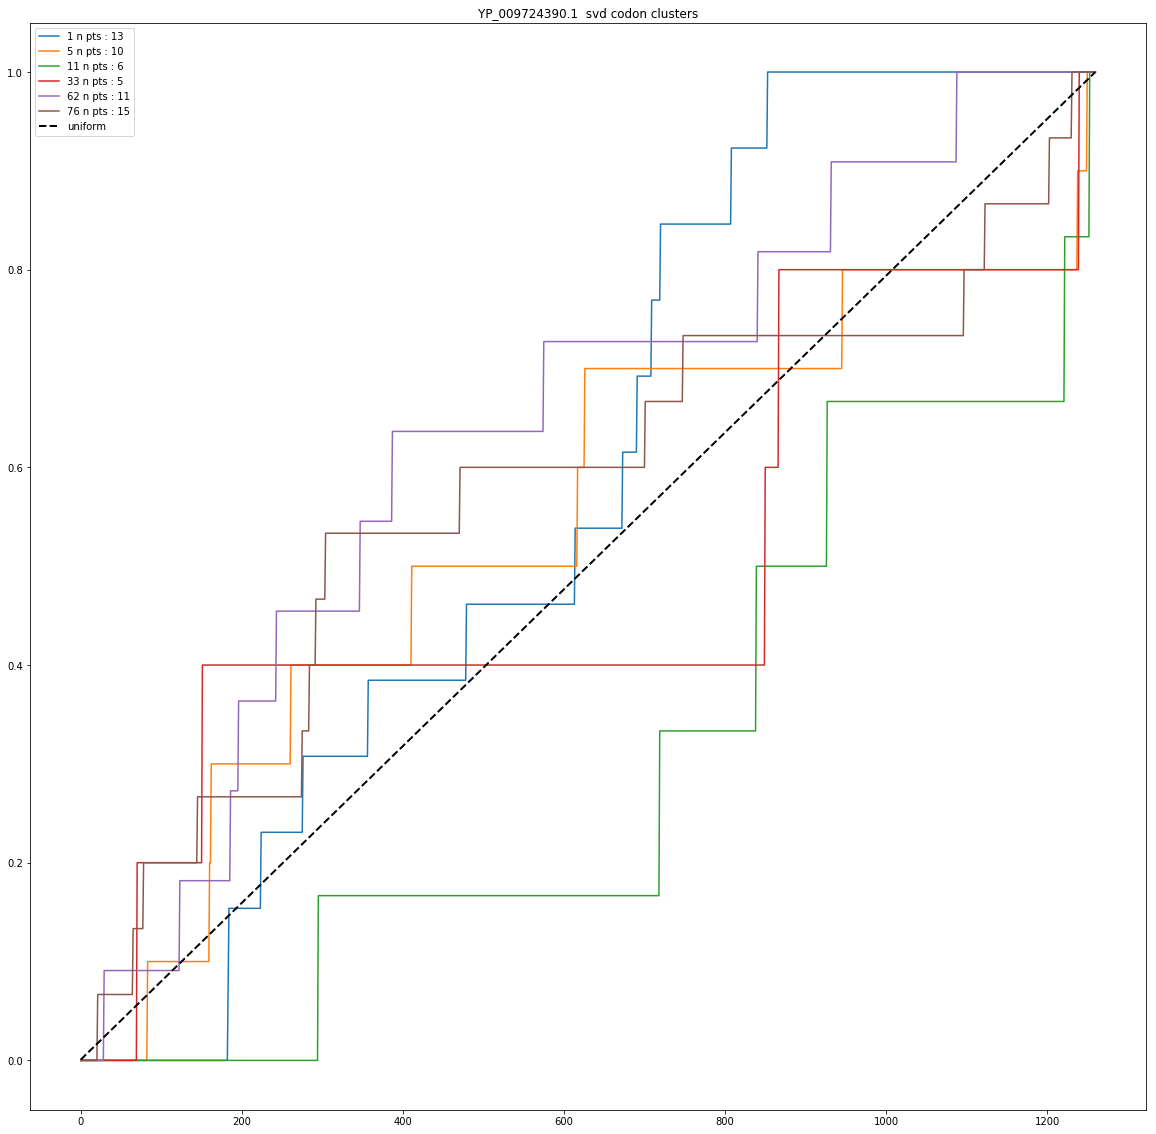

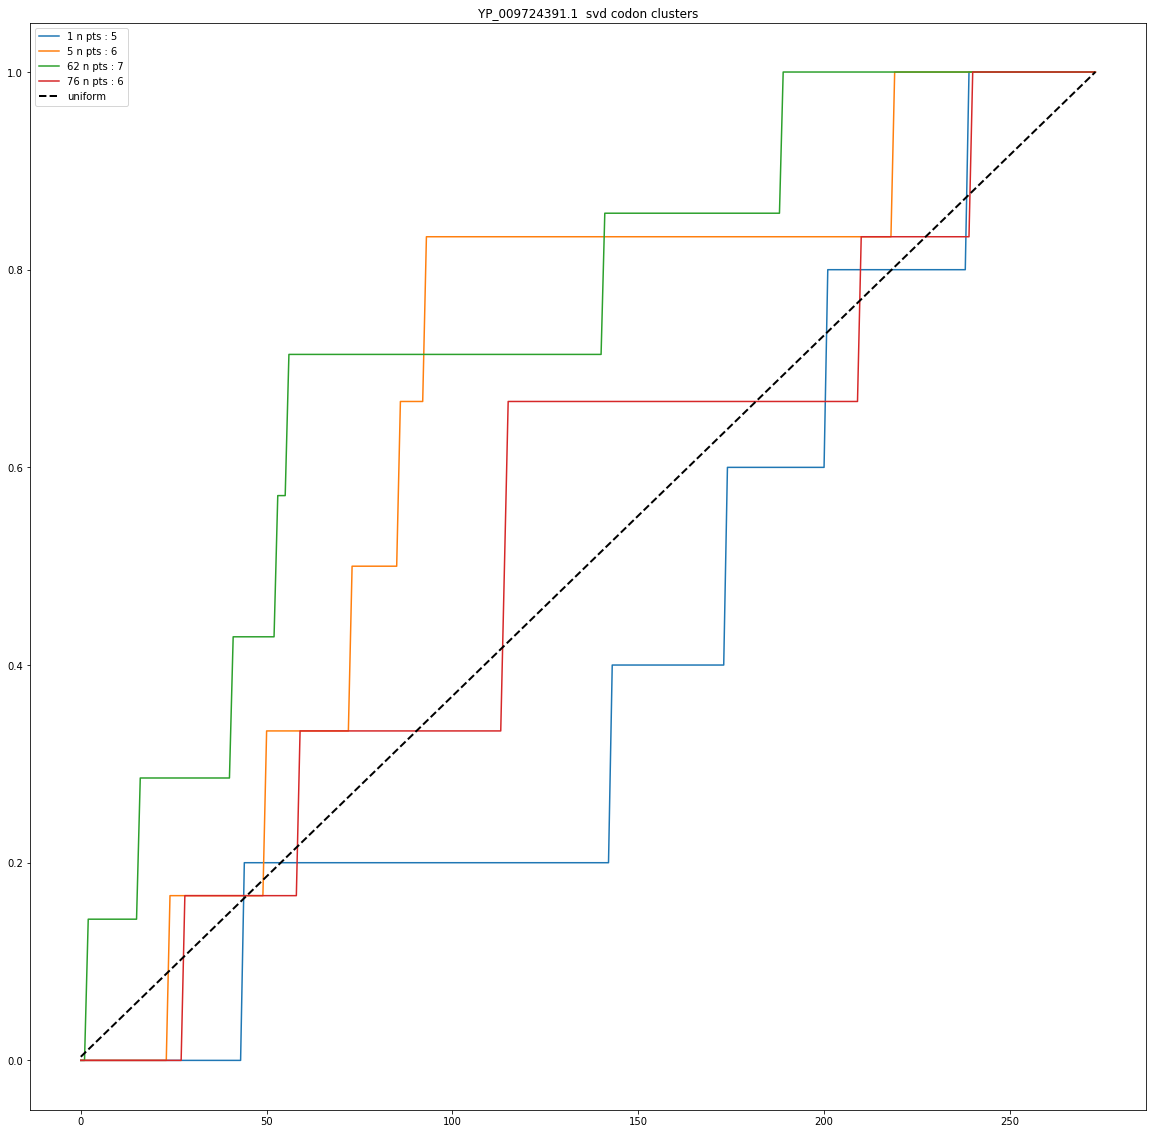

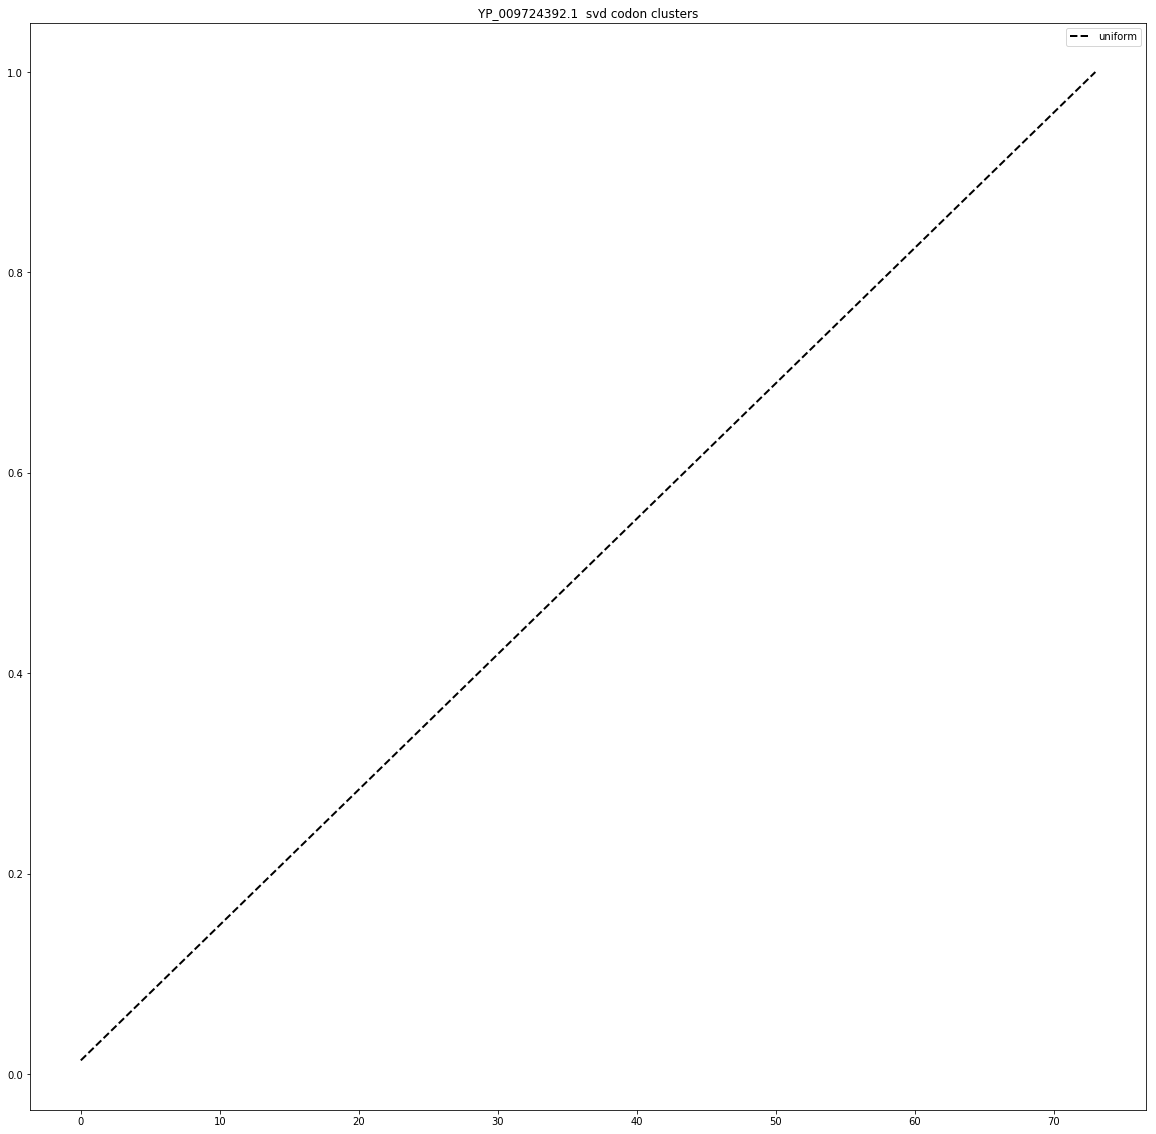

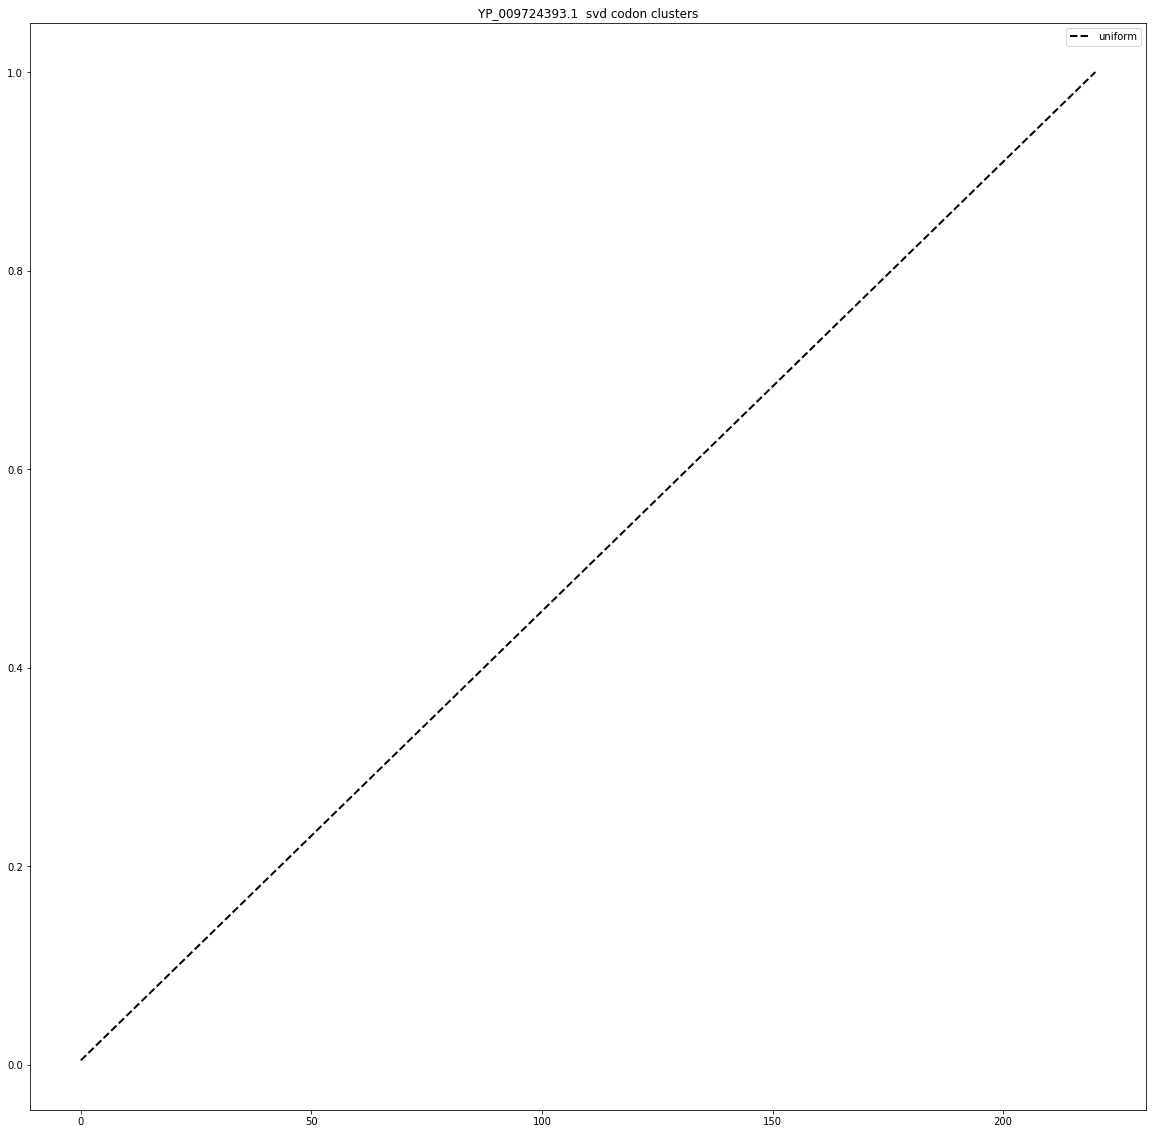

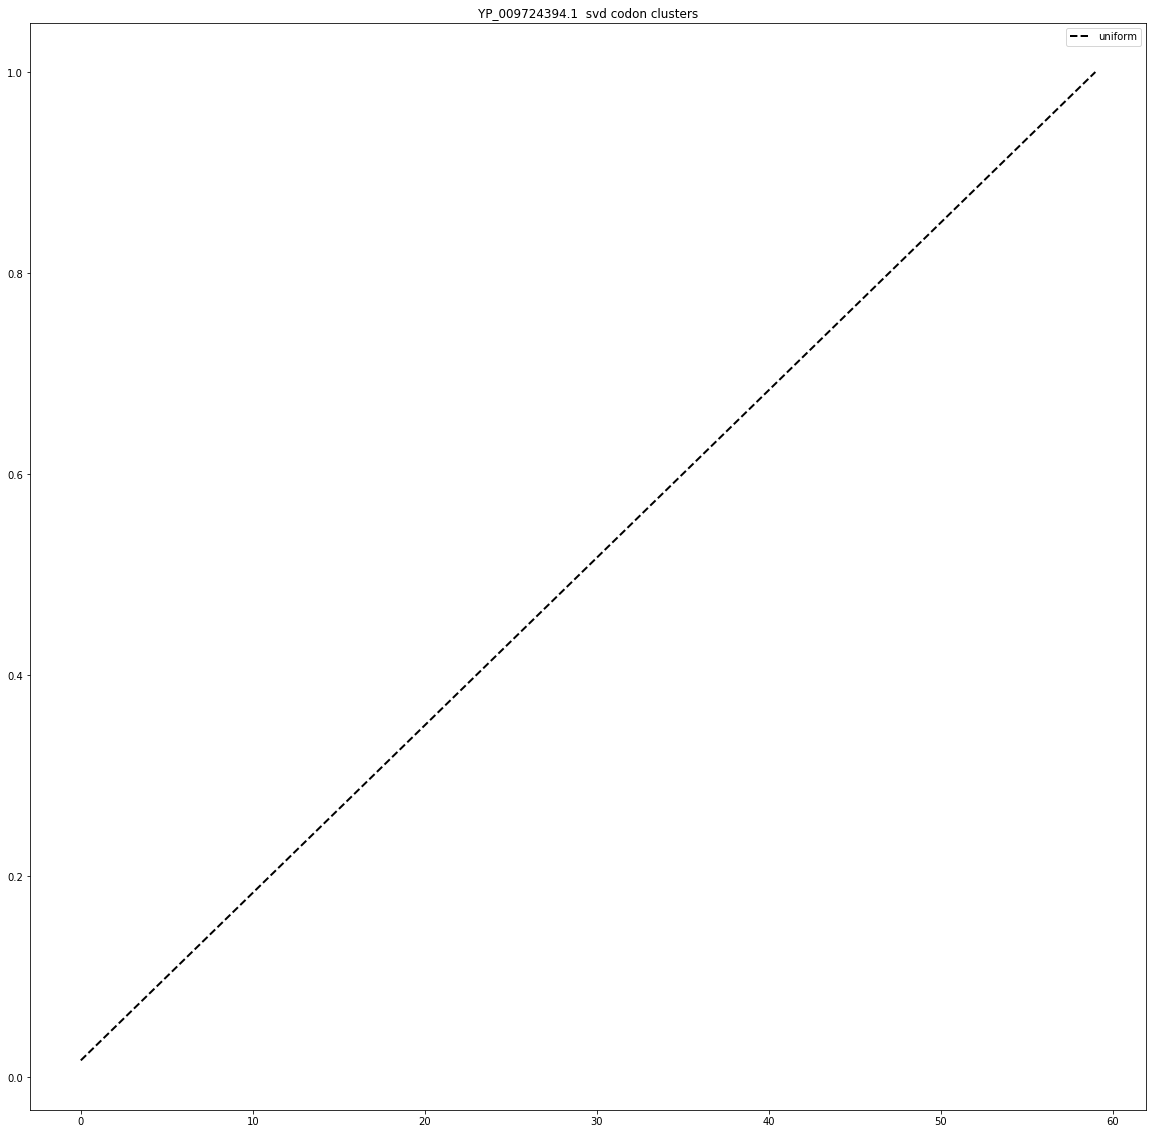

1
(array([ True,  True,  True,  True,  True,  True,  True]), array([3.09966928e-016, 2.71289903e-245, 3.27439581e-032, 1.39397072e-024,
       3.57847973e-043, 3.80653682e-117, 6.44230258e-025]), 0.007300831979014655, 0.0071428571428571435)
5
(array([ True,  True,  True,  True]), array([2.83437749e-043, 1.86875951e-111, 1.08403681e-045, 1.25834070e-061]), 0.012741455098566168, 0.0125)
62
(array([ True,  True,  True,  True,  True]), array([2.27898509e-039, 1.54591944e-172, 1.92213256e-069, 9.67749959e-122,
       6.82393741e-066]), 0.010206218313011495, 0.01)
76
(array([ True,  True,  True,  True,  True,  True,  True]), array([4.38040258e-52, 3.15211717e-63, 2.16178441e-31, 6.00340940e-38,
       4.61776470e-35, 4.60129911e-95, 2.32916236e-14]), 0.007300831979014655, 0.0071428571428571435)
4
(array([ True]), array([9.00672773e-214]), 0.050000000000000044, 0.05)
7
(array([ True]), array([1.27406349e-174]), 0.050000000000000044, 0.05)
11
(array([ True,  True]), array([4.03023066e-156, 1.2

In [195]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
#over the whole genome
titles = ' codon clusters, svd codon clusters'.split(',')


for k,dataset in enumerate(titles):
    bonferroni1 = []
    bonferroni2= {}
    for j,row in annotation[annotation[dataset].notna()].iterrows():
        plt.figure( figsize=(20,20))
        
        for cluster in row[dataset]:
            
            
            cluster_ones = np.zeros(len(row.prots))        
            cluster_ones[ row[dataset][cluster] ] = 1  
            if np.sum(cluster_ones) > 4 and np.sum(cluster_ones) < 1000 :    
                cdf_empirical= np.cumsum(cluster_ones) / np.sum(cluster_ones)
                res = stats.kstest(cdf_empirical, 'uniform')
                plt.plot( cdf_empirical  , label = str(cluster) + ' n pts : '+ str(int(np.sum(cluster_ones)) ) )
                bonferroni1.append(res[1])
                if cluster not in bonferroni2:
                    bonferroni2[cluster]=[]
                bonferroni2[cluster].append(res[1])
        cdf_uniform = np.cumsum(np.ones(len(row.prots)) ) / np.sum(len(row.prots))
        plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')
        plt.legend()
        plt.title( row.sseqid + ' ' + titles[k] )
        plt.show()
        
    for c in bonferroni2:
        print(c)
        bf_correction = multipletests(bonferroni2[c], alpha=0.05 , method='bonferroni', is_sorted=False, returnsorted=False)
        print(bf_correction)
    
    bf_correction = multipletests(bonferroni, alpha=0.05 , method='bonferroni', is_sorted=False, returnsorted=False)
    print(bf_correction)
    